# Imports

In [1]:
import os
os.chdir('C:/Users/wgabr/Jupyter Notebooks/TCC/')
print(os.getcwd())


C:\Users\wgabr\Jupyter Notebooks\TCC


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
import json
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta
from scipy.signal import filtfilt, cheby2, butter, savgol_filter, medfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.stats import skew, kurtosis, zscore
import pywt

from config_json import SAMPLES4_FREQ800, SAMPLES8_FREQ1000, DEFAULT_PARAMS

# Funções de ajuda

## Leitura do arquivo

In [3]:
def read_file(data_file):
    """Read the entire JSON file."""
    with open(data_file, 'r') as file:
        data = json.load(file)
    return data

def read_measure(data_file, measure_number):
    """
    Read a specific measure from the JSON file by appending the number to 'measure_'.

    Parameters:
        data_file (str): Path to the JSON file.
        measure_number (int or str): The number to append to 'measure_' (e.g., 1 for 'measure_1').

    Returns:
        dict: The requested measure if it exists.
        None: If the requested measure does not exist.
    """
    with open(data_file, 'r') as file:
        data = json.load(file)

    # Construct the measure key by appending the number to 'measure_'
    measure_key = f"measure_{measure_number}"

    # Get the requested measure by its key
    measure = data.get(measure_key)

    if measure is None:
        print(f"Measure '{measure_key}' not found in the data.")
    return measure

def read_last_measure(data_file):
    """Read the last measure from the JSON file."""
    with open(data_file, 'r') as file:
        data = json.load(file)

    # Assuming measures are stored in a dictionary under keys like "measure_x", "measure_y", ...
    measures = list(data.values())
    
    # Get the last measure (based on the order of appearance in the JSON)
    last_measure = measures[-1]  # JSON order of keys is preserved in Python 3.7+
    return last_measure

def read_all_measures(data_file):
    """Read all measures from the JSON file."""
    with open(data_file, 'r') as file:
        data = json.load(file)
    
    # Extract all measures
    all_measures = list(data.values())
    return all_measures

def parse_signal(signal_str):
    """Parse the signal string into a list of floats."""
    return [float(x.strip()) for x in signal_str.split(',')]

# Example of parsing signal data:
def get_parsed_signals(data):
    """Parse the signals dictionary in a measure."""
    parsed_signals = {
        key: parse_signal(value)
        for key, value in data.get("signals", {}).items()
    }
    return parsed_signals

## Filtering

### Time Domain

In [4]:
def moving_average(signal, window_size):
    """Apply a moving average filter to the given signal."""
    return np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

def chebyshev_filter(signal, measure_time, lowcut=0.01, highcut=15.0, order=4, attenuation=40):
    """Apply a Chebyshev-II bandpass filter to a signal. """
    num_values = len(signal)
    fs = num_values / measure_time
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Design the Chebyshev-II filter
    b, a = cheby2(order, attenuation, [low, high], btype='bandpass')
    
    # Apply the filter and normalize
    filtered_signal = normalize(filtfilt(b, a, signal))
    
    return filtered_signal

def savitzky_golay(signal, window_size, poly_order):
    """Apply a Savitzky-Golay filter to the signal."""
    return savgol_filter(signal, window_length=window_size, polyorder=poly_order)

def gaussian_smoothing(signal, sigma):
    """Apply Gaussian smoothing to the signal."""
    return gaussian_filter1d(signal, sigma=sigma)

def median_filter(signal, kernel_size):
    """Apply a median filter to the signal."""
    return medfilt(signal, kernel_size=kernel_size)

def low_pass_filter(signal, cutoff_freq, fs, order=4):
    """Apply a low-pass Butterworth filter to the signal."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

def exponential_smoothing(signal, alpha):
    """Apply exponential smoothing to the signal."""
    smoothed = np.zeros_like(signal)
    smoothed[0] = signal[0]
    for i in range(1, len(signal)):
        smoothed[i] = alpha * signal[i] + (1 - alpha) * smoothed[i - 1]
    return smoothed

def wavelet_denoising(signal, wavelet='db4', level=1):
    """Denoise the signal using wavelet transform."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(signal))) * np.std(coeffs[-1])
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)

def kalman_filter(signal, process_variance, measurement_variance):
    """Apply a Kalman filter to the signal."""
    n = len(signal)
    estimates = np.zeros(n)
    estimation_error = np.zeros(n)
    gain = np.zeros(n)
    
    estimates[0] = signal[0]
    estimation_error[0] = process_variance

    for i in range(1, n):
        # Prediction
        estimates[i] = estimates[i - 1]
        estimation_error[i] = estimation_error[i - 1] + process_variance
        
        # Update
        gain[i] = estimation_error[i] / (estimation_error[i] + measurement_variance)
        estimates[i] += gain[i] * (signal[i] - estimates[i])
        estimation_error[i] *= (1 - gain[i])
    
    return estimates

def bilateral_filter(signal, spatial_sigma, intensity_sigma):
    """Apply a bilateral filter to the signal (custom 1D implementation)."""
    smoothed = np.zeros_like(signal)
    for i in range(len(signal)):
        weights = np.exp(-0.5 * ((np.arange(len(signal)) - i) / spatial_sigma)**2)
        intensity_diff = signal - signal[i]
        intensity_weights = np.exp(-0.5 * (intensity_diff / intensity_sigma)**2)
        total_weights = weights * intensity_weights
        smoothed[i] = np.sum(total_weights * signal) / np.sum(total_weights)
    return smoothed

def fourier_filter(signal, cutoff_freq, fs):
    """Apply Fourier-based low-pass filter to the signal."""
    freqs = np.fft.fftfreq(len(signal), d=1/fs)
    fft_signal = np.fft.fft(signal)
    fft_signal[np.abs(freqs) > cutoff_freq] = 0
    return np.fft.ifft(fft_signal).real

def fourier_bandpass_filter(signal, fs, low_cutoff=0.1, high_cutoff=10):
    """Apply Fourier-based bandpass filter to the signal while preserving baseline."""
    # Compute the frequency bins
    freqs = np.fft.fftfreq(len(signal), d=1/fs)
    
    # Perform FFT
    fft_signal = np.fft.fft(signal)
    
    # Save the DC component
    dc_component = fft_signal[0]
    
    # Zero out frequencies outside the bandpass range
    fft_signal[(np.abs(freqs) < low_cutoff) | (np.abs(freqs) > high_cutoff)] = 0
    
    # Restore the DC component if low_cutoff > 0
    if low_cutoff > 0:
        fft_signal[0] = dc_component
    
    # Inverse FFT to get the filtered signal
    return np.fft.ifft(fft_signal).real

### Frequency Domain

In [5]:
def compute_fft(signal, sampling_frequency):
    """Compute FFT and corresponding frequencies."""
    signal = signal - np.mean(signal) # Removes DC component
    N = len(signal)
    fft_values = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_values[:N // 2])  # Only take the positive frequencies
    freqs = np.fft.fftfreq(N, d=1 / sampling_frequency)[:N // 2]  # Corresponding frequencies
    return freqs, fft_magnitude

## Quality Index

### New

In [6]:
def calculate_energy_percentage(frequencies, fft_magnitude, min_freq=0.1, max_freq=10.0):
    """
    Calculate the percentage of signal energy within a specified frequency range.

    Parameters:
    - frequencies: Array of frequency bins (Hz)
    - fft_magnitude: FFT magnitude (or power spectrum) corresponding to the frequencies
    - min_freq: Lower bound of the frequency range (Hz, default 0.1)
    - max_freq: Upper bound of the frequency range (Hz, default 10.0)

    Returns:
    - energy_percentage: Percentage of energy within the specified range
    """
    # Calculate the power spectrum
    power_spectrum = np.abs(fft_magnitude) ** 2
    
    # Total energy of the signal
    total_energy = np.sum(power_spectrum)
    
    # Find indices within the desired frequency range
    indices_in_range = (frequencies >= min_freq) & (frequencies <= max_freq)
    
    # Energy within the desired range
    range_energy = np.sum(power_spectrum[indices_in_range])
    
    # Percentage of energy in the desired range
    energy_percentage = (range_energy / total_energy) * 100
    return energy_percentage

### Old

In [7]:
def preprocess_file(data_file, window_size):
    """
    Analyze all measures in the file.
    Processes signals, applies filters, and computes FFTs.
    
    Returns:
        results (list): A list of dictionaries containing processed data.
    """
    # Read all measures
    all_measures = read_all_measures(data_file)
    
    results = []  # To store processed data for each measure

    # Iterate over all measures
    for idx, measure in enumerate(all_measures):
        # Parse the measure
        timestamp, measureTime, redSignal, irSignal = parse_measure(measure)
        
        # Get the parsed datetime, measure time, and measure frequency
        formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)
        
        # Apply moving average filter
        redSignal_mov_avg = moving_average(redSignal, window_size)
        irSignal_mov_avg = moving_average(irSignal, window_size)

        # Apply Chebyshev-II filter
        redSignal_cheby = chebyshev_filter_std(redSignal, measureTime)
        irSignal_cheby = chebyshev_filter_std(irSignal, measureTime)
        
        # Store results in a dictionary
        results.append({
            "index": idx + 1,
            "datetime": formatted_datetime,
            "frequency": measureFrequency,
            "measure_time": measureTime,
            "red_original": redSignal,
            "ir_original": irSignal,
            "red_mov_avg": redSignal_mov_avg,
            "ir_mov_avg": irSignal_mov_avg,
            "red_cheby": redSignal_cheby,
            "ir_cheby": irSignal_cheby
        })
    
    return results

def analyze_quality_indices(results):
    """
    Calculate skewness and kurtosis for each measure in the results.
    
    Args:
        results (list): List of dictionaries containing processed measures.

    Returns:
        dict: Dictionary containing mean skewness and kurtosis for all signals.
    """
    quality_indices = {
        "red_ori_skew": [], "ir_ori_skew": [],
        "red_ori_kurt": [], "ir_ori_kurt": [],
        "red_mov_skew": [], "ir_mov_skew": [],
        "red_mov_kurt": [], "ir_mov_kurt": [],
        "red_cheby_skew": [], "ir_cheby_skew": [],
        "red_cheby_kurt": [], "ir_cheby_kurt": []
    }

    for result in results:
        quality_indices["red_ori_skew"].append(skew(result["red_original"]))
        quality_indices["ir_ori_skew"].append(skew(result["ir_original"]))
        quality_indices["red_ori_kurt"].append(kurtosis(result["red_original"], fisher=True))
        quality_indices["ir_ori_kurt"].append(kurtosis(result["ir_original"], fisher=True))

        quality_indices["red_mov_skew"].append(skew(result["red_mov_avg"]))
        quality_indices["ir_mov_skew"].append(skew(result["ir_mov_avg"]))
        quality_indices["red_mov_kurt"].append(kurtosis(result["red_mov_avg"], fisher=True))
        quality_indices["ir_mov_kurt"].append(kurtosis(result["ir_mov_avg"], fisher=True))

        quality_indices["red_cheby_skew"].append(skew(result["red_cheby"]))
        quality_indices["ir_cheby_skew"].append(skew(result["ir_cheby"]))
        quality_indices["red_cheby_kurt"].append(kurtosis(result["red_cheby"], fisher=True))
        quality_indices["ir_cheby_kurt"].append(kurtosis(result["ir_cheby"], fisher=True))

    # Calculate mean values
    mean_quality_indices = {key: np.mean(values) for key, values in quality_indices.items()}
    return mean_quality_indices

def process_multiple_files(file_list, window_size):
    """
    Process multiple files and analyze their quality indices.
    
    Args:
        file_list (list): List of file paths to process.
        window_size (int): Window size for the moving average filter.
    
    Returns:
        dict: Aggregated results for all files.
    """
    all_file_results = {}

    for file_path in file_list:
        print(f"Processing file: {file_path}")
        results = preprocess_file(file_path, window_size)
        quality_indices = analyze_quality_indices(results)
        all_file_results[file_path] = quality_indices
    
    return all_file_results

## Signal Processing

In [8]:
def normalize(data, range_min=0, range_max=1):
    """Normalize the input data to a specified range."""
    data = np.array(data)  # Ensure input is a numpy array for easier manipulation
    data_min = np.min(data)
    data_max = np.max(data)

    # Avoid division by zero if all values in data are the same
    if data_max == data_min:
        return np.full_like(data, range_min)  # Fill with the minimum of the range

    # Normalize to [0, 1] and then scale to the desired range
    normalized_data = (data - data_min) / (data_max - data_min)
    normalized_data = normalized_data * (range_max - range_min) + range_min

    return normalized_data

def interpolate_signal(signal, original_frequency, target_frequency):
    """Interpolate a signal to increase the number of samples."""
    duration = len(signal) / original_frequency  # Total duration of the signal
    original_time = np.linspace(0, duration, len(signal))
    target_time = np.linspace(0, duration, int(len(signal) * (target_frequency / original_frequency)))
    interpolator = interp1d(original_time, signal, kind='cubic')  # Cubic interpolation
    return interpolator(target_time), target_time

def zero_pad_signal(signal, target_length):
    """Pad a signal with zeros to achieve the desired length."""
    current_length = len(signal)
    if target_length > current_length:
        padding = target_length - current_length
        return np.pad(signal, (0, padding), mode='constant')
    else:
        return signal  # Return as is if already long enough
    
def detect_peaks(signal, distance, prominence):
    """Detects pulse peaks to calculate the heart rate."""
    peaks, _ = find_peaks(signal, distance=distance, prominence=prominence)
    return peaks

def detect_onset_offset(signal, peaks):
    """"Detects the start and the end of the pulses."""
    onsets = []
    offsets = []
    for peak in peaks:
        # Detect onset
        onset = peak
        while onset > 0 and signal[onset] > signal[onset - 1]:
            onset -= 1
        onsets.append(onset)
        
        # Detect offset
        offset = peak
        while offset < len(signal) - 1 and signal[offset] > signal[offset + 1]:
            offset += 1
        offsets.append(offset)
    return onsets, offsets

def compute_phases(signal, onsets, offsets, peaks):
    """Detects the anacrotic and catacrotic phases of the signal."""
    phases = []
    for onset, peak, offset in zip(onsets, peaks, offsets):
        anacrotic = signal[onset:peak]
        catacrotic = signal[peak:offset]
        phases.append((anacrotic, catacrotic))
    return phases

def detect_dicrotic_notch(signal, peaks, offsets):
    """Detects the dicrotic notchs of the signal."""
    notches = []
    for peak, offset in zip(peaks, offsets):
        catacrotic_phase = signal[peak:offset]
        notch = np.argmin(catacrotic_phase) + peak
        notches.append(notch)
    return notches



## Plotting

### Time Analysis

In [18]:
def plot_signal_comparison(filterName, redSignal, irSignal, filteredRedSignal, filteredIrSignal, 
                           measureFrequency, formatted_datetime, measureTime=0, xmin=None, xmax=None):
    """Plot original and filtered signals with optional time-based x-axis."""
    plt.figure(figsize=(12, 5))  # Adjust figure size as needed
    
    # Generate x-axis (samples or time)
    if measureTime > 0:
        x_axis = np.linspace(0, measureTime, len(redSignal))
        x_label = 'Time (s)'
    else:
        x_axis = np.arange(len(redSignal))
        x_label = 'Número da Amostra'
    
    # Plot the signals
    plt.plot(x_axis, redSignal, label='Sinal Red Original', linewidth=1, alpha=0.75, color='lightcoral')
    plt.plot(x_axis, irSignal, label='Sinal IR Original', linewidth=1, alpha=0.75, color='lightblue')
    plt.plot(x_axis, filteredRedSignal, label='Sinal Red Filtrado', linewidth=1.25, color='red')
    plt.plot(x_axis, filteredIrSignal, label='Sinal IR Filtrado', linewidth=1.25, color='royalblue')
    plt.plot([], label=f'Frequência de Medição: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency
    
    # Set labels and title
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.title(f'Comparativo de Sinais: {filterName} - {formatted_datetime}', fontsize=14)
    
    # Add grid and legend
    plt.grid(True)
    plt.legend(fontsize=11)
    
    # Set x-axis range if specified
    if xmin is not None or xmax is not None:
        plt.xlim(xmin, xmax)
    
    # Display the plot
    plt.tight_layout()
    plt.show()


def plot_interp_signal_comparison(filterName, redSignal, irSignal, filteredRedSignal, filteredIrSignal, measureFrequency, target_freq, measureTime, formatted_datetime, xmin=None,xmax=None):
    # Generate time axes
    original_time = np.linspace(0, measureTime, len(redSignal))
    interpolated_time = np.linspace(0, measureTime, len(filteredRedSignal))
    
    # Create a single plot
    plt.figure(figsize=(12, 5))  # Adjust figure size as needed
    
    # Plot the signals
    plt.plot(original_time, redSignal, label='Original Red Signal', linewidth = 3, alpha = 0.75, color='lightcoral')
    plt.plot(original_time, irSignal, label='Original IR Signal', linewidth = 3, alpha = 0.75, color='lightblue')
    plt.plot(interpolated_time, filteredRedSignal, label=f'Filtered Red Signal [{target_freq} Hz]', linewidth=0.5, alpha = 1, color='red')
    plt.plot(interpolated_time, filteredIrSignal, label=f'Filtered IR Signal [{target_freq} Hz]', linewidth=0.5, alpha = 1, color='royalblue')
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency

    # Set axis labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.title(f'Signal Comparison: {filterName} - {formatted_datetime}')
    plt.legend()
    plt.grid(True)

    # Set x-axis range if specified
    if xmin is not None or xmax is not None:
        plt.xlim(xmin, xmax)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

    return

def plot_original_maf(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_red_signal, filtered_ir_signal):
    # Create a single plot
    plt.figure(figsize=(12, 5))  # Adjust figure size as needed
    
    # Plot the signals
    plt.plot(redSignal, label='Original Red Signal', linewidth=0.75, alpha = 0.75, color='lightcoral')
    plt.plot(irSignal, label='Original IR Signal', linewidth=0.75, alpha = 0.75, color='lightblue')
    plt.plot(filtered_red_signal, label='Filtered Red Signal [Moving Average]', linewidth=1.25, color='red')
    plt.plot(filtered_ir_signal, label='Filtered IR Signal [Moving Average]', linewidth=1.25, color='royalblue')
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Moving Average Filters Comparison - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

    return

def plot_original_cheby_comp(irSignal, measureFrequency, formatted_datetime, irSignalStd, irSignalCustom):
    # Create a single plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    
    # Plot the signals
    plt.plot(irSignal, label='Original IR Signal', linewidth=1)
    plt.plot(irSignalStd, label='Filtered IR Signal [Cheby Std]', linewidth=1.5)
    plt.plot(irSignalCustom, label='Filtered IR Signal [Cheby Custom]', linewidth=1.5)
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Chebyshev Filters Comparison - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.tight_layout()
    plt.show()

    return

def plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_red_signal, filtered_ir_signal):
    # Create a figure with two subplots arranged side by side
    plt.figure(figsize=(12, 4))  # Adjust figure size as needed
    
    # Plot the original signals on the first subplot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(redSignal, label='Original Red Signal')
    plt.plot(irSignal, label='Original IR Signal')
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Original Signals - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Plot the filtered signals on the second subplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(filtered_red_signal, label='Filtered Red Signal', linewidth=2)
    plt.plot(filtered_ir_signal, label='Filtered IR Signal', linewidth=2)
    plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.title(f'Filtered Signals (Moving Average) - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Adjust layout to avoid overlapping elements
    plt.tight_layout()
    plt.show()

    return

### Spectral Analysis

In [10]:
def plot_fft(plot_type, redSignal, irSignal, filtered_red_signal, filtered_ir_signal, measureFrequency, formatted_datetime, xmin = None, xmax = None, ymin = None, ymax = None):
    # Compute Signals FFT
    red_freqs, red_fft = compute_fft(redSignal, measureFrequency)
    ir_freqs, ir_fft = compute_fft(irSignal, measureFrequency)
    filtered_red_freqs, filtered_red_fft = compute_fft(filtered_red_signal, measureFrequency)
    filtered_ir_freqs, filtered_ir_fft = compute_fft(filtered_ir_signal, measureFrequency)

    # Create a single plot
    plt.figure(figsize=(12, 5))  # Adjust figure size as needed
    
    # Plot the signals
    if plot_type == 1:
        plt.loglog(red_freqs, red_fft, label='Original Red Signal FFT', linewidth=0.75, alpha = 0.75, color='lightcoral')
        plt.loglog(ir_freqs, ir_fft, label='Original IR Signal FFT', linewidth=0.75, alpha = 0.75, color='lightblue')
        plt.loglog(filtered_red_freqs, filtered_red_fft, label='Filtered Red Signal FFT', linewidth=1.25, color='red')
        plt.loglog(filtered_ir_freqs, filtered_ir_fft, label='Filtered IR Signal FFT', linewidth=1.25, color='royalblue')
        plt.loglog([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency
    elif plot_type == 2:
        plt.semilogx(red_freqs, red_fft, label='Original Red Signal FFT', linewidth=0.75, alpha = 0.75, color='lightcoral')
        plt.semilogx(ir_freqs, ir_fft, label='Original IR Signal FFT', linewidth=0.75, alpha = 0.75, color='lightblue')
        plt.semilogx(filtered_red_freqs, filtered_red_fft, label='Filtered Red Signal FFT', linewidth=1.25, color='red')
        plt.semilogx(filtered_ir_freqs, filtered_ir_fft, label='Filtered IR Signal FFT', linewidth=1.25, color='royalblue')
        plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency
    elif plot_type == 3:
        plt.semilogy(red_freqs, red_fft, label='Original Red Signal FFT', linewidth=0.75, alpha = 0.75, color='lightcoral')
        plt.semilogy(ir_freqs, ir_fft, label='Original IR Signal FFT', linewidth=0.75, alpha = 0.75, color='lightblue')
        plt.semilogy(filtered_red_freqs, filtered_red_fft, label='Filtered Red Signal FFT', linewidth=1.25, color='red')
        plt.semilogy(filtered_ir_freqs, filtered_ir_fft, label='Filtered IR Signal FFT', linewidth=1.25, color='royalblue')
        plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')  # Dummy label for frequency

    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title(f'Signals FFTs Comparison - {formatted_datetime}')
    plt.legend()
    plt.grid(True)
    
    # Set y-axis range if specified
    if ymin is not None or ymax is not None:
        plt.ylim(ymin, ymax)

    # Set x-axis range if specified
    if xmin is not None or xmax is not None:
        plt.xlim(xmin, xmax)

    # Add legend and grid
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

    return





# Exemplo de Medida

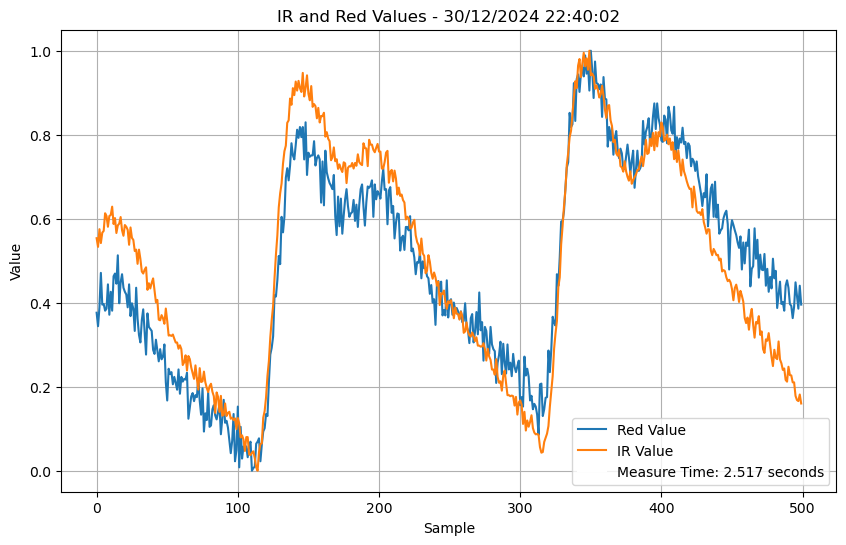

In [9]:
# Path to the CSV file
data_file = SAMPLES4_FREQ800

# Read entire file
data = read_file(data_file)

# Read the last measure
measure = read_last_measure(data_file)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Extract the list
redSignal = parsed_signals.get("redMeasure", [])
irSignal = parsed_signals.get("irMeasure", [])
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(redSignal, label='Red Value')
plt.plot(irSignal, label='IR Value')
plt.plot([], label=f'Measure Time: {measureTime} seconds', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'IR and Red Values - {timestamp}')
plt.legend()
plt.grid(True)

plt.show()


# SNR

## Default Parameters

### Moving Average Filter

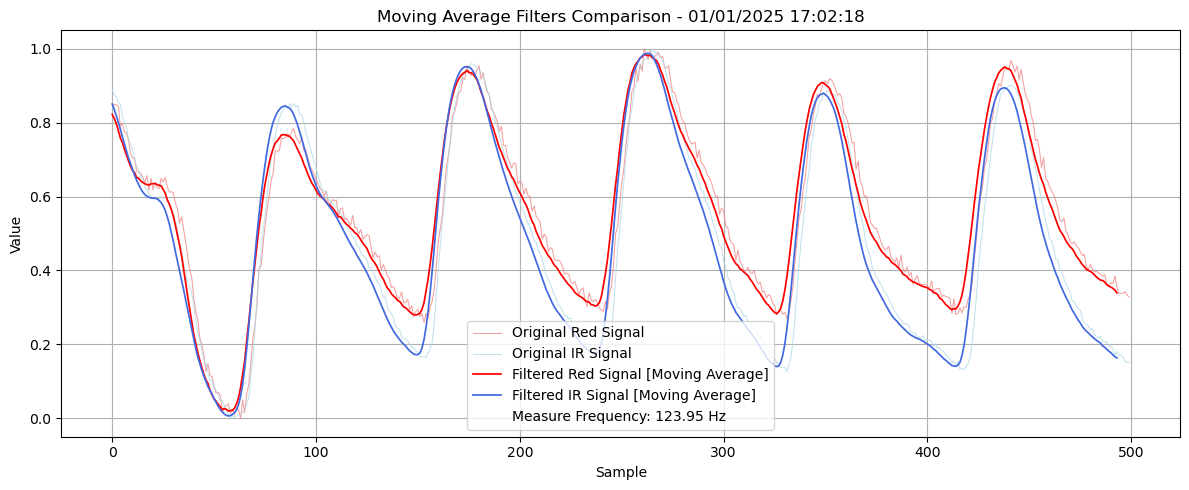

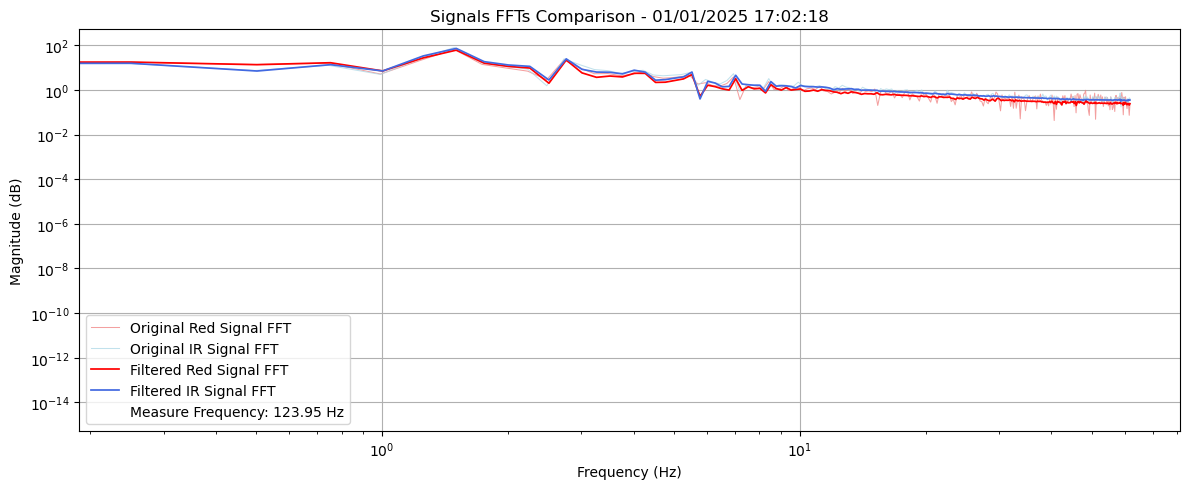

In [16]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = moving_average(redSignal, 7)
irFilteredSignal = moving_average(irSignal, 7)

# Plots
plot_original_maf(redSignal, irSignal, measureFrequency, timestamp, redFilteredSignal, irFilteredSignal)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Chebyshev II

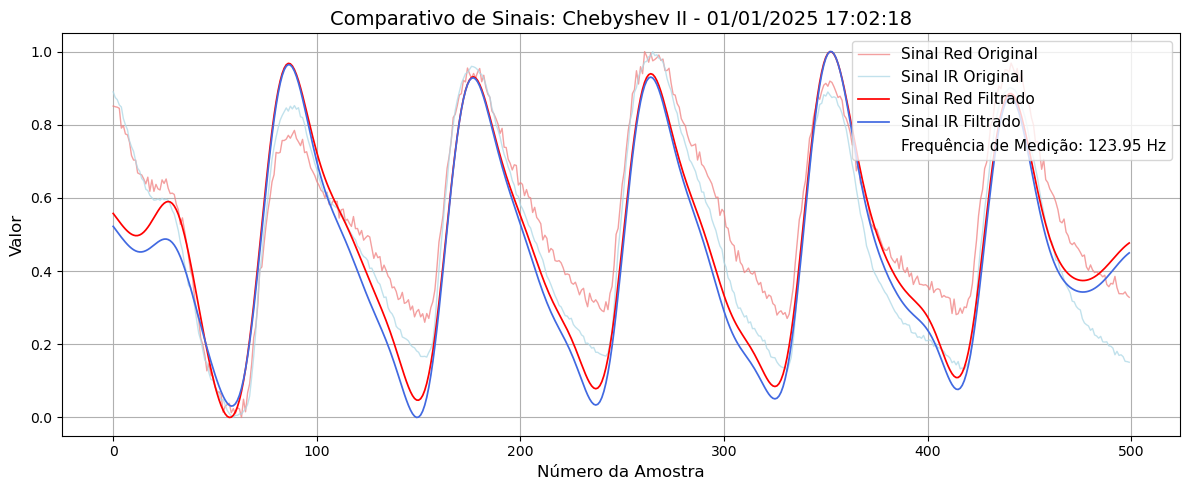

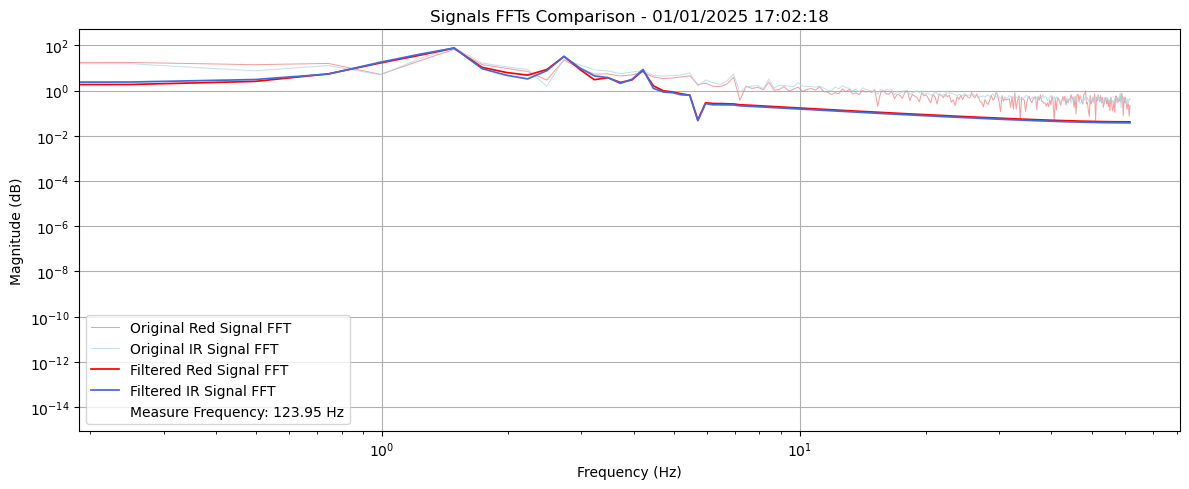

In [24]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Filter Parameters
lpf = 0.5
hpf = 8
order = 4
attenuation = 40

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = chebyshev_filter(redSignal, measureTime, lpf, hpf, order, attenuation)
irFilteredSignal = chebyshev_filter(irSignal, measureTime, lpf, hpf, order, attenuation)

# Plots
plot_signal_comparison("Chebyshev II", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Savitzky-Golay Filter

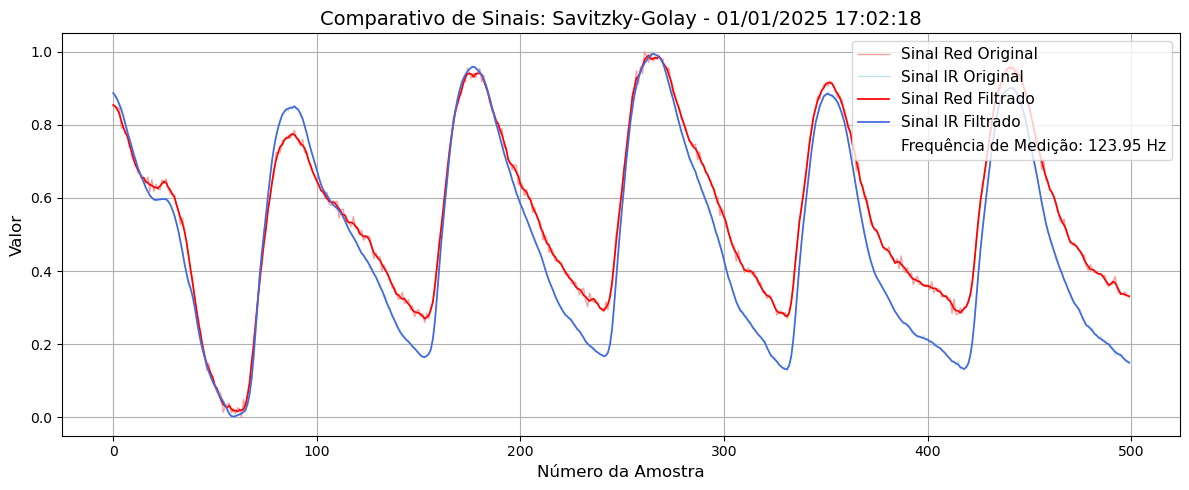

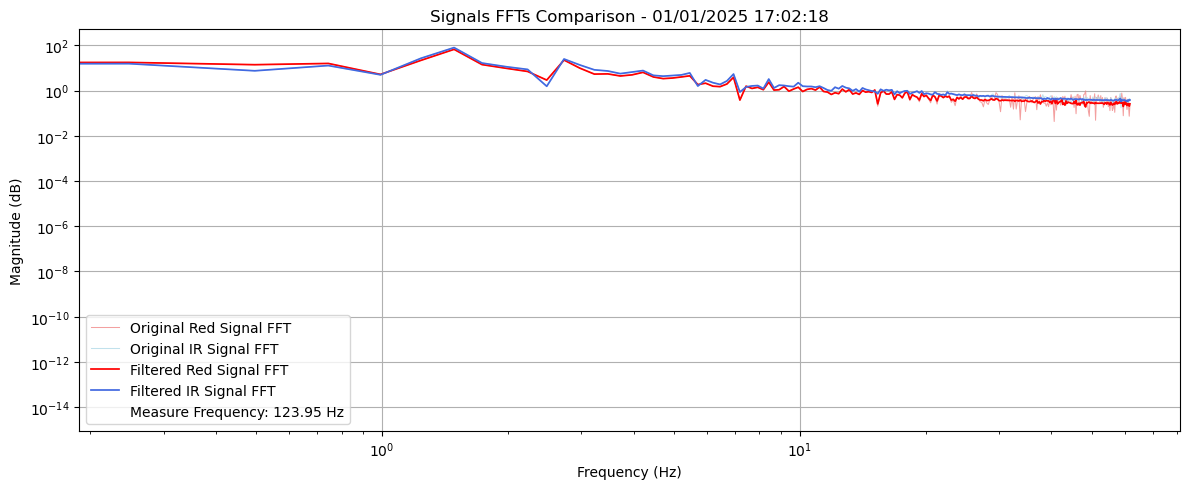

In [23]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = savgol_filter(redSignal, 7, 2)
irFilteredSignal = savgol_filter(irSignal, 7, 2)

# Plots
plot_signal_comparison("Savitzky-Golay", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Gaussian Smoothing

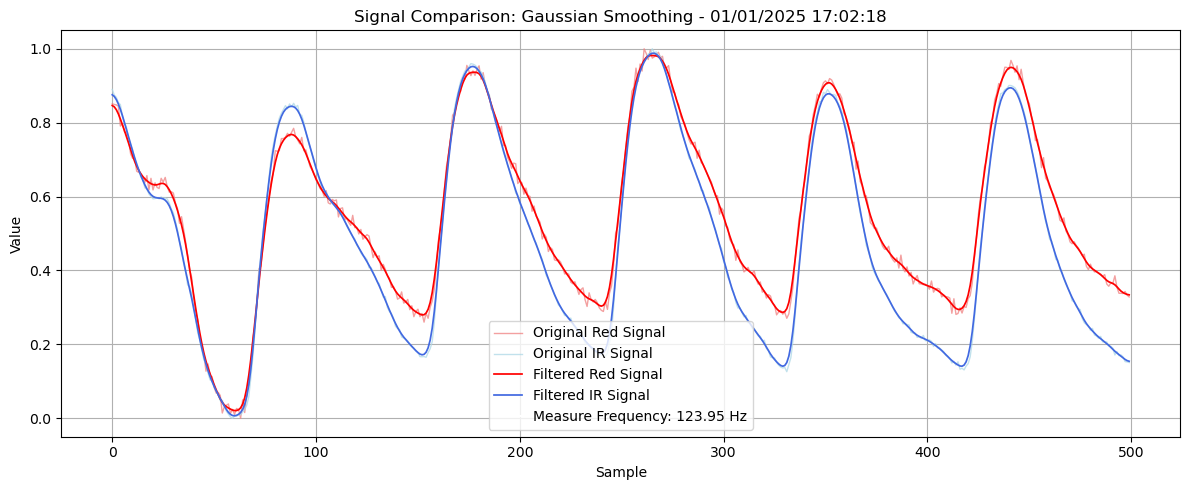

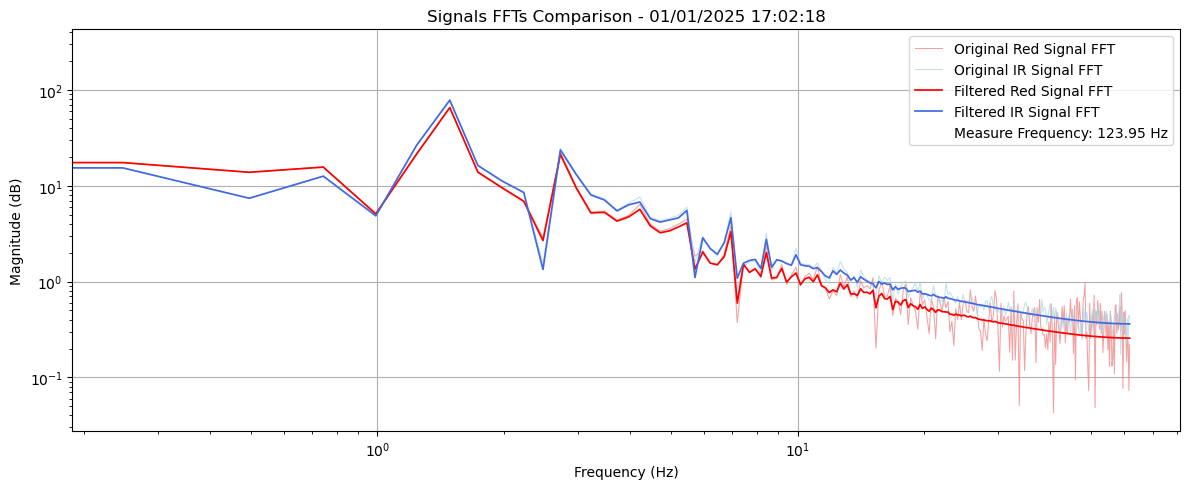

In [254]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = gaussian_smoothing(redSignal, 2)
irFilteredSignal = gaussian_smoothing(irSignal, 2)

# Plots
plot_signal_compariston("Gaussian Smoothing", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Median Filter

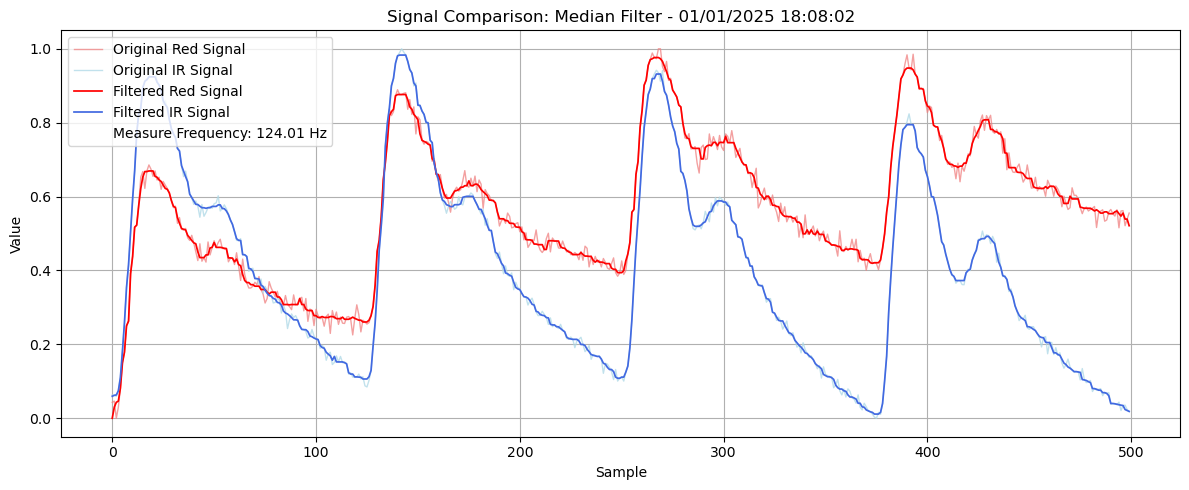

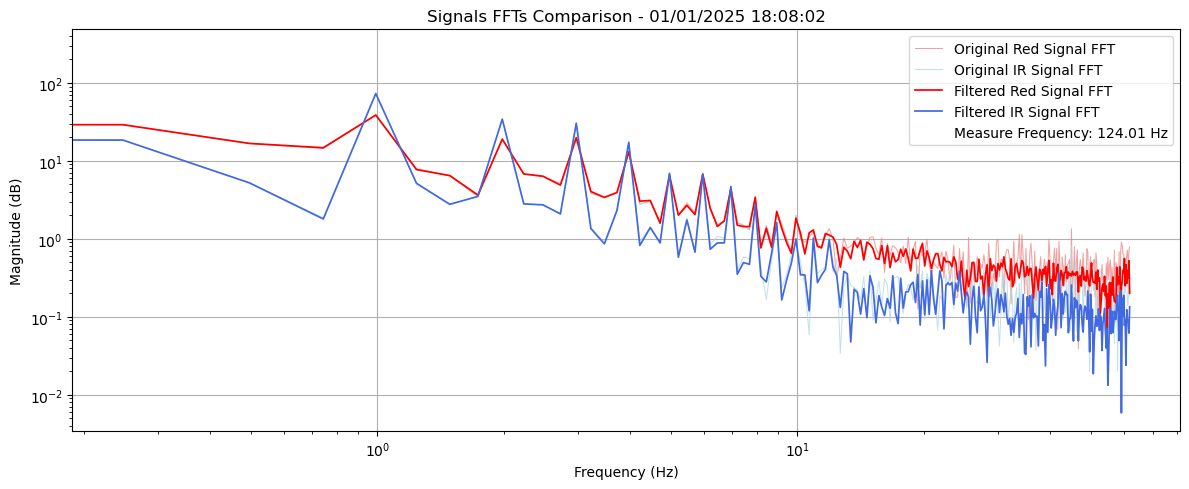

In [253]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = median_filter(redSignal, 7)
irFilteredSignal = median_filter(irSignal, 7)

# Plots
plot_signal_compariston("Median Filter", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Butterworth Filter

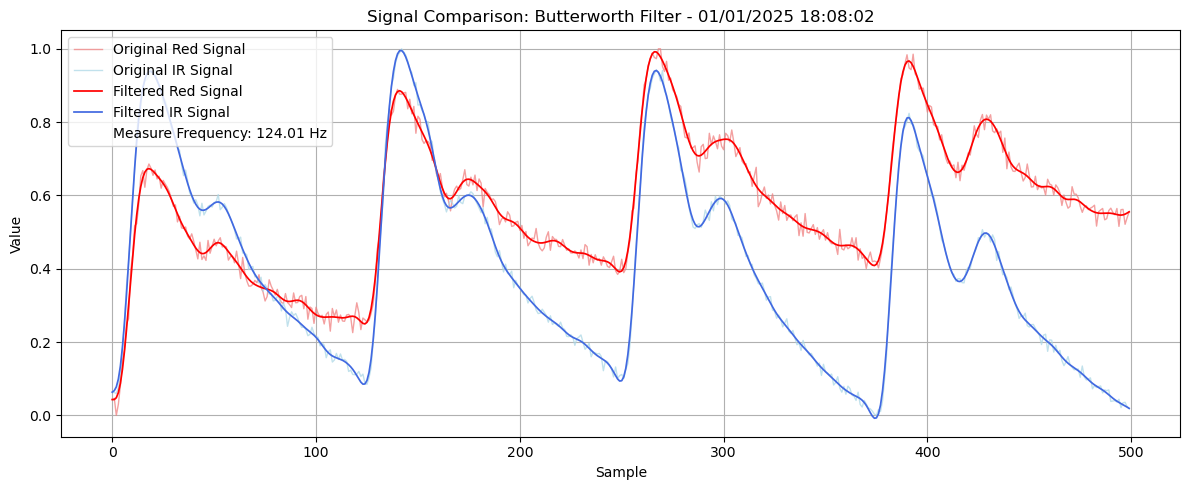

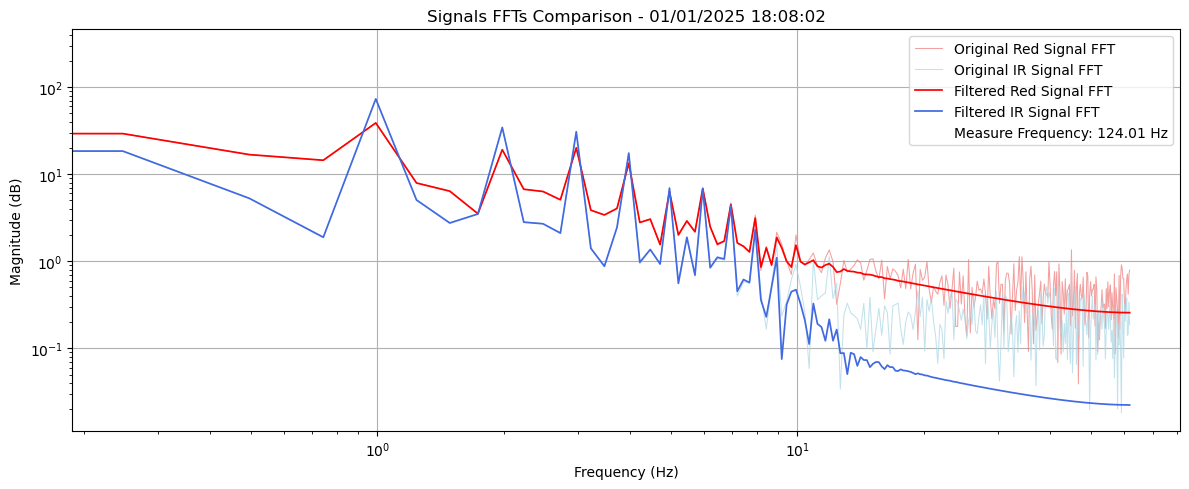

In [256]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = low_pass_filter(redSignal, 10, measureFrequency)
irFilteredSignal = low_pass_filter(irSignal, 10, measureFrequency)

# Plots
plot_signal_compariston("Butterworth Filter", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Exponential Smoothing

In [257]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = exponential_smoothing(redSignal, 0.25)
irFilteredSignal = exponential_smoothing(irSignal, 0.25)


In [258]:
# Calculate the energy per frequency range of the signals
red_freqs, red_fft = compute_fft(redSignal, measureFrequency)
ir_freqs, ir_fft = compute_fft(irSignal, measureFrequency)
filtered_red_freqs, filtered_red_fft = compute_fft(redFilteredSignal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft = compute_fft(irFilteredSignal, measureFrequency)

red_energy_percentage = calculate_energy_percentage(red_freqs, red_fft, 0, 10)
ir_energy_percentage = calculate_energy_percentage(ir_freqs, ir_fft, 0, 10)
red_filtered_energy_percentage = calculate_energy_percentage(filtered_red_freqs, filtered_red_fft, 0, 10)
ir_filtered_energy_percentage = calculate_energy_percentage(filtered_ir_freqs, filtered_ir_fft, 0, 10)

print(f'Original Red Signal %: {red_energy_percentage:.6f}')
print(f'Original IR Signal %: {ir_energy_percentage:.6f}')
print(f'Filtered Red Signal %: {red_filtered_energy_percentage:.6f}')
print(f'Filtered IR Signal %: {ir_filtered_energy_percentage:.6f}')

Original Red Signal %: 99.927747
Original IR Signal %: 99.866612
Filtered Red Signal %: 99.950528
Filtered IR Signal %: 99.879726


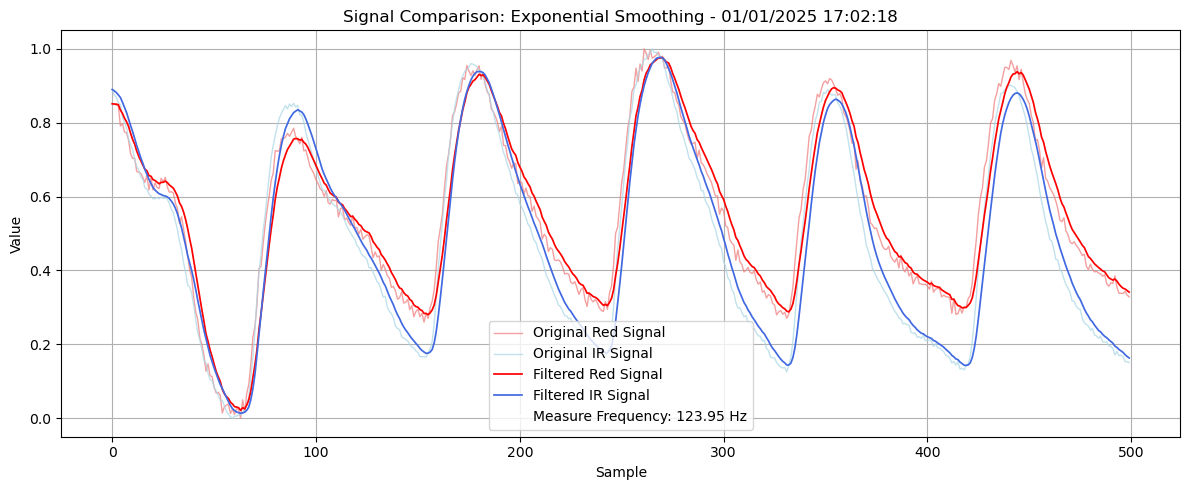

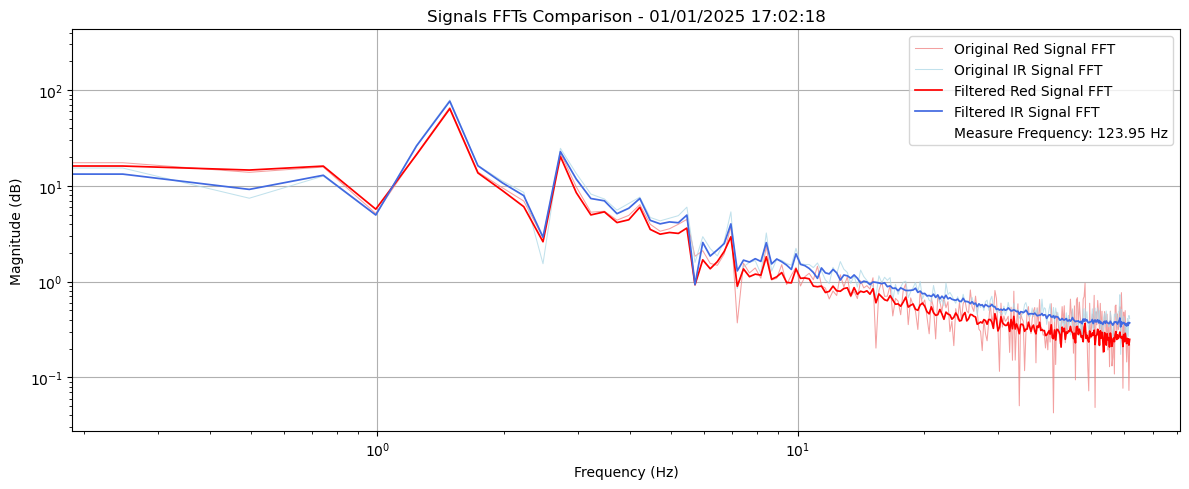

In [260]:
# Plots
plot_signal_compariston("Exponential Smoothing", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Wavelet Denoising


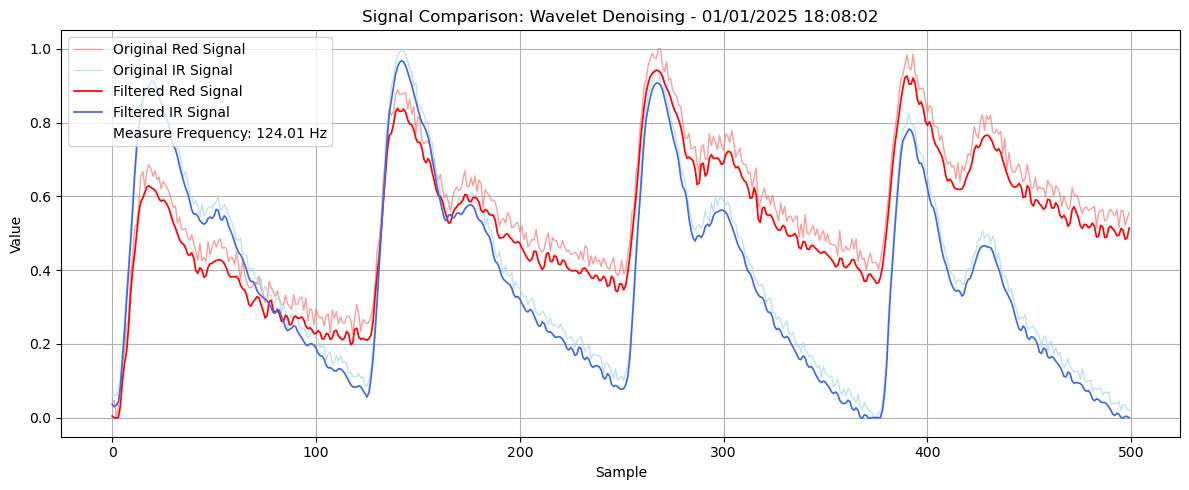

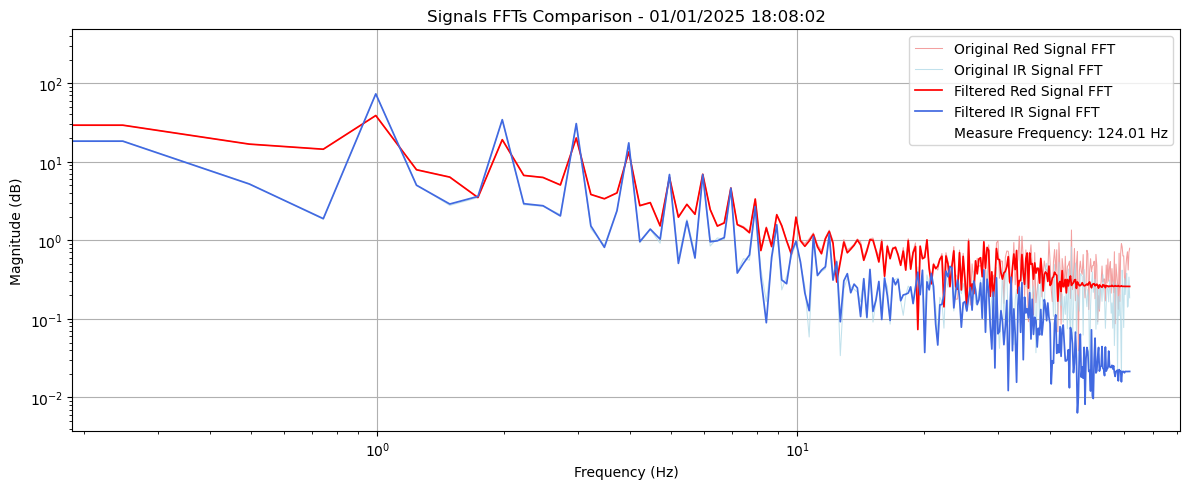

In [262]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = wavelet_denoising(redSignal)
irFilteredSignal = wavelet_denoising(irSignal)

# Plots
plot_signal_compariston("Wavelet Denoising", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Fourier Transform Filtering

In [486]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Signal Parameters
lf = 0.1
hf = 10

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = fourier_filter(redSignal, 10, measureFrequency)
irFilteredSignal = fourier_filter(irSignal, 10, measureFrequency)

# Calculate the energy per frequency range of the signals
red_freqs, red_fft = compute_fft(redSignal, measureFrequency)
ir_freqs, ir_fft = compute_fft(irSignal, measureFrequency)
filtered_red_freqs, filtered_red_fft = compute_fft(redFilteredSignal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft = compute_fft(irFilteredSignal, measureFrequency)

red_energy_percentage = calculate_energy_percentage(red_freqs, red_fft, lf, hf)
ir_energy_percentage = calculate_energy_percentage(ir_freqs, ir_fft, lf, hf)
red_filtered_energy_percentage = calculate_energy_percentage(filtered_red_freqs, filtered_red_fft, lf, hf)
ir_filtered_energy_percentage = calculate_energy_percentage(filtered_ir_freqs, filtered_ir_fft, lf, hf)

print(f'Original Red Signal %: {red_energy_percentage:.6f}')
print(f'Original IR Signal %: {ir_energy_percentage:.6f}')
print(f'Filtered Red Signal %: {red_filtered_energy_percentage:.6f}')
print(f'Filtered IR Signal %: {ir_filtered_energy_percentage:.6f}')

Original Red Signal %: 98.263182
Original IR Signal %: 99.793901
Filtered Red Signal %: 100.000000
Filtered IR Signal %: 100.000000


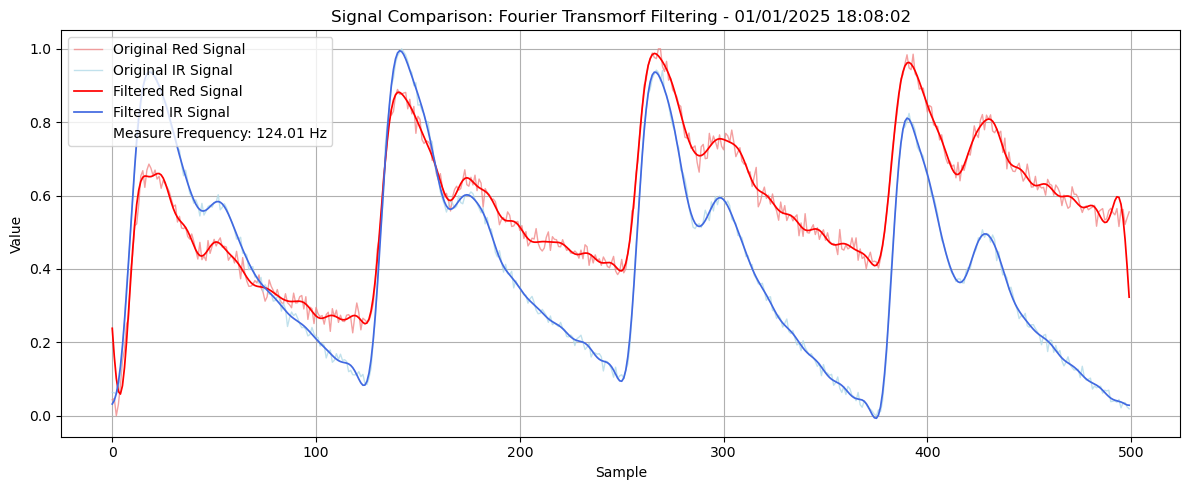

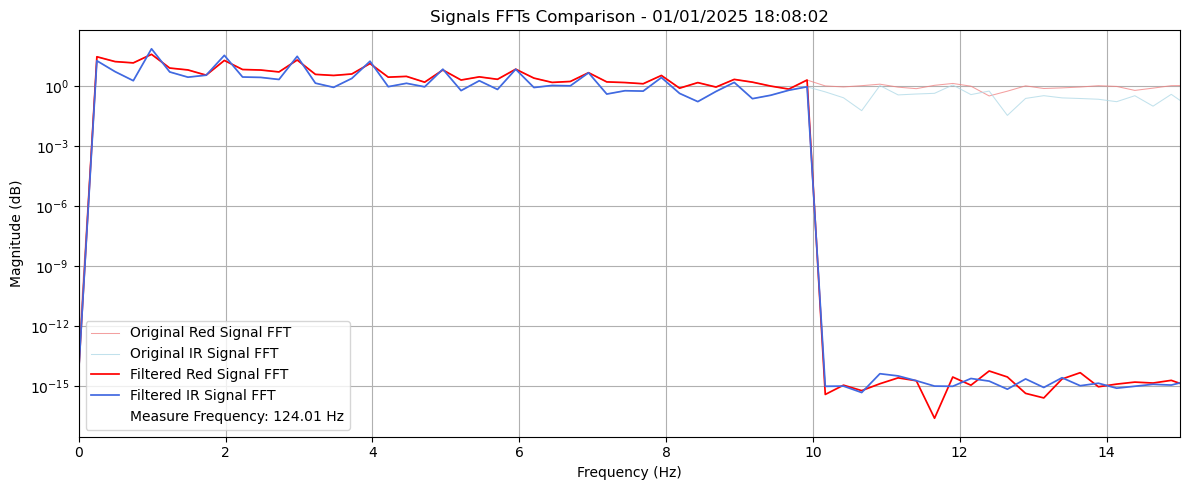

In [497]:
# Plots
plot_signal_compariston("Fourier Transmorf Filtering", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(3, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp, 10**(-10), 15)

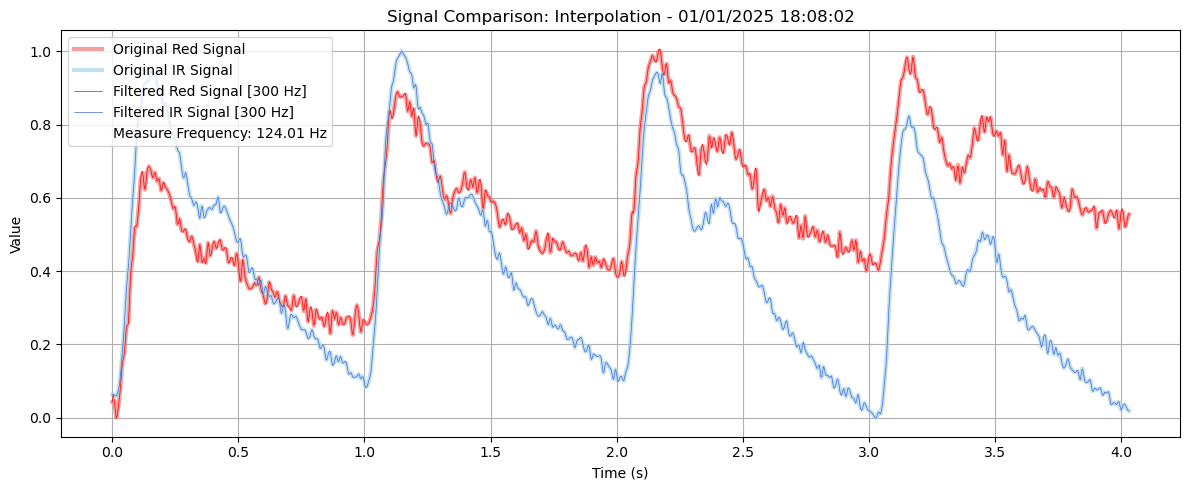

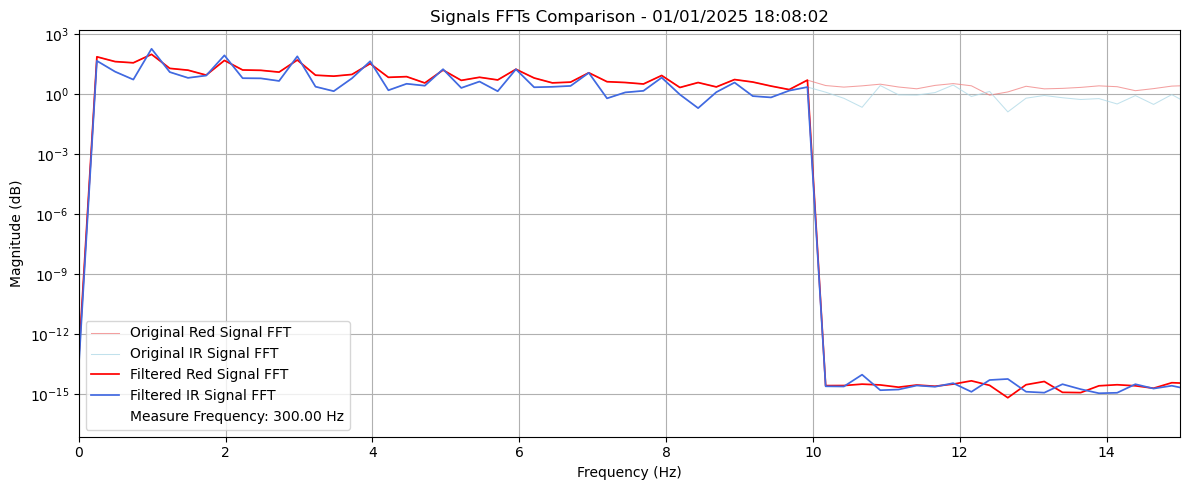

In [490]:
# Interpolated Signals
target_freq = 300
redSignalInterpolated, target_time = interpolate_signal(redSignal, measureFrequency, target_freq)
irSignalInterpolated , target_time = interpolate_signal(irSignal,  measureFrequency, target_freq)
redFilteredSignalInterpolated = fourier_filter(redSignalInterpolated, 10, target_freq)
irFilteredSignalInterpolated = fourier_filter(irSignalInterpolated, 10, target_freq)

#plot_signal_compariston("Fourier Transmorf Filtering", redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp)
plot_interp_signal_compariston("Interpolation", redSignal, irSignal, redSignalInterpolated, irSignalInterpolated, measureFrequency, target_freq, measureTime, timestamp)
plot_fft(3, redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp, 0, 15)

### Fourier Transform Filtering (Bandpass)

In [455]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 40)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = fourier_bandpass_filter(redSignal, measureFrequency) # args: signal, fs, lf, hf
irFilteredSignal = fourier_bandpass_filter(irSignal, measureFrequency)

# Calculate the energy per frequency range of the signals
red_freqs, red_fft = compute_fft(redSignal, measureFrequency)
ir_freqs, ir_fft = compute_fft(irSignal, measureFrequency)
filtered_red_freqs, filtered_red_fft = compute_fft(redFilteredSignal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft = compute_fft(irFilteredSignal, measureFrequency)

red_energy_percentage = calculate_energy_percentage(red_freqs, red_fft, 0.1, 10)
ir_energy_percentage = calculate_energy_percentage(ir_freqs, ir_fft, 0.1, 10)
red_filtered_energy_percentage = calculate_energy_percentage(filtered_red_freqs, filtered_red_fft, 0.1, 10)
ir_filtered_energy_percentage = calculate_energy_percentage(filtered_ir_freqs, filtered_ir_fft, 0.1, 10)

print(f'Original Red Signal %: {red_energy_percentage:.6f}')
print(f'Original IR Signal %: {ir_energy_percentage:.6f}')
print(f'Filtered Red Signal %: {red_filtered_energy_percentage:.6f}')
print(f'Filtered IR Signal %: {ir_filtered_energy_percentage:.6f}')


Original Red Signal %: 99.120917
Original IR Signal %: 99.022358
Filtered Red Signal %: 100.000000
Filtered IR Signal %: 100.000000


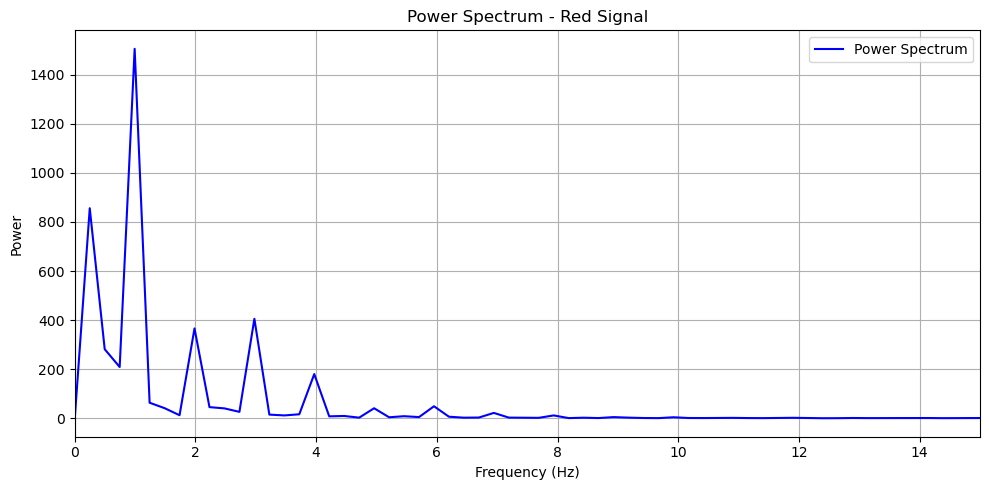

In [500]:
def plot_power_spectrum(frequencies, power_spectrum, title="Power Spectrum"):
    """Plot the power spectrum of the signal."""
    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, power_spectrum, label="Power Spectrum", color='blue')
    #plt.axvline(0.1, color='red', linestyle='--', label="0.1 Hz Threshold")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.xlim(0, 15)
    plt.tight_layout()
    plt.show()

# Calculate the power spectrum for the red signal
red_freqs, red_fft = compute_fft(redSignal, measureFrequency)
red_power_spectrum = np.abs(red_fft) ** 2

# Plot the power spectrum
plot_power_spectrum(red_freqs, red_power_spectrum, title="Power Spectrum - Red Signal")

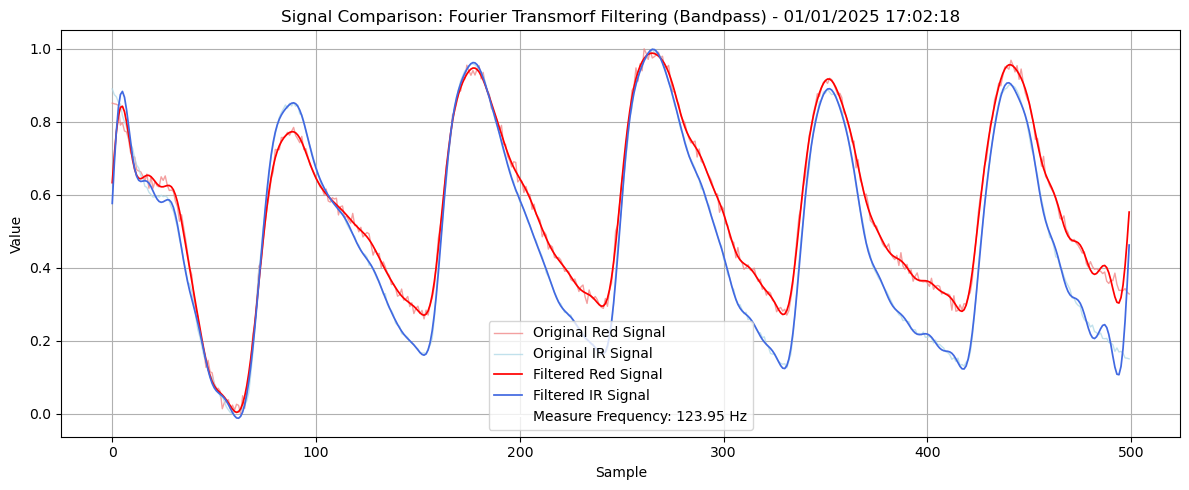

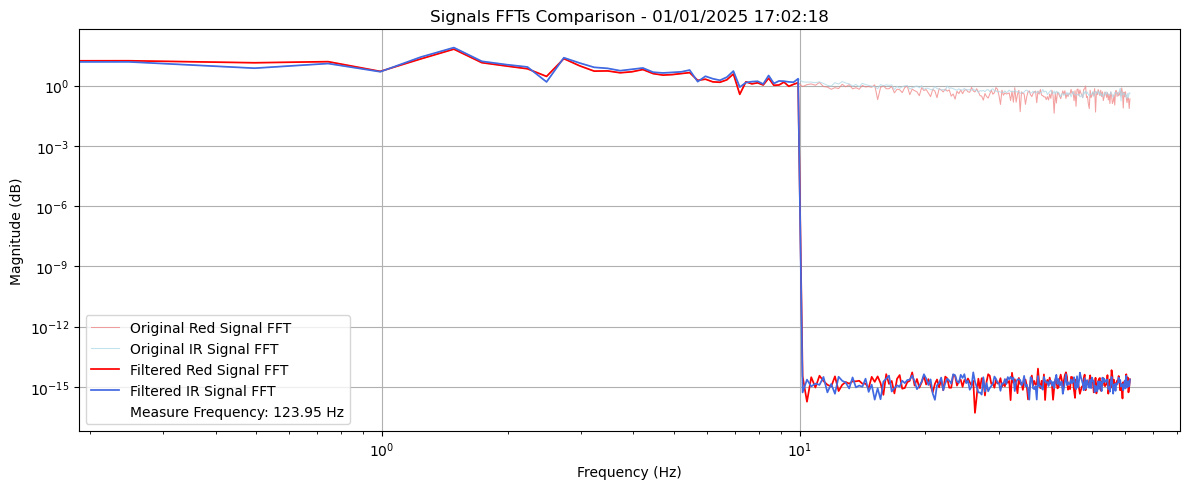

In [457]:
# Plots
plot_signal_comparison("Fourier Transmorf Filtering (Bandpass)", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)
plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

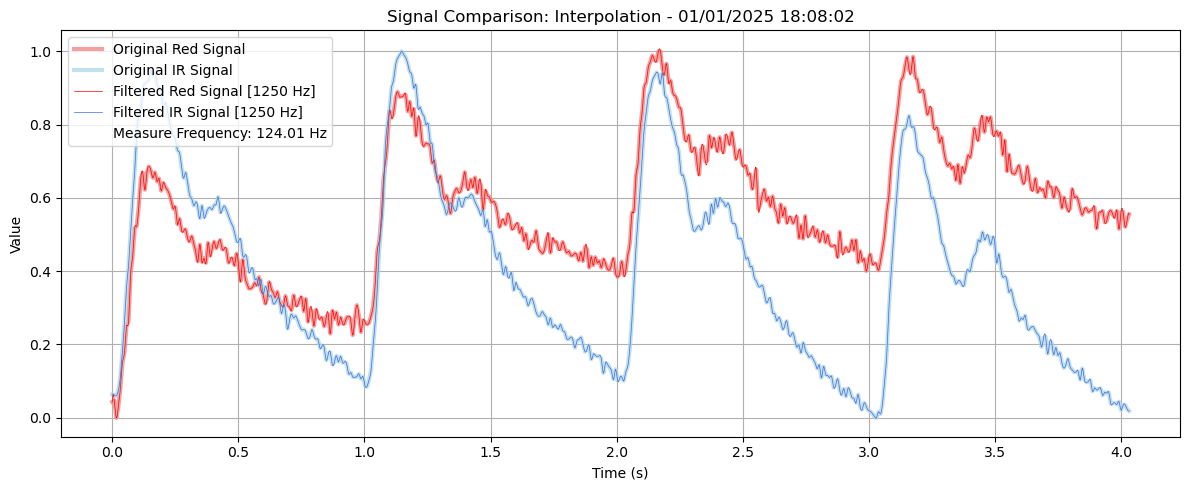

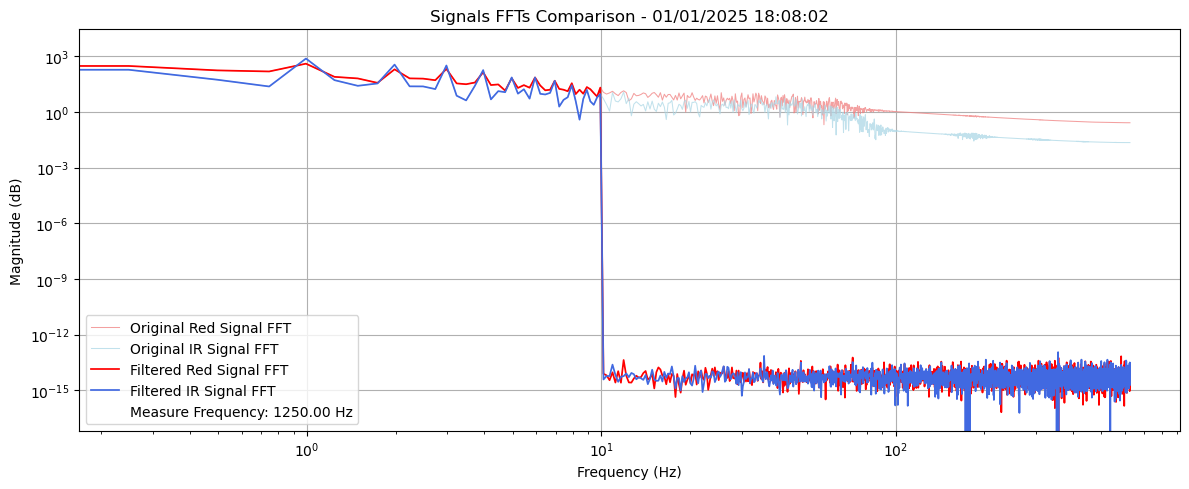

In [344]:
# Interpolated Signals
target_freq = 1250
redSignalInterpolated, target_time = interpolate_signal(redSignal, measureFrequency, target_freq)
irSignalInterpolated , target_time = interpolate_signal(irSignal,  measureFrequency, target_freq)
redFilteredSignalInterpolated = fourier_bandpass_filter(redSignalInterpolated, target_freq) # args: signal, fs, lf, hf
irFilteredSignalInterpolated = fourier_bandpass_filter(irSignalInterpolated, target_freq)

#plot_signal_compariston("Fourier Transmorf Filtering", redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp)
plot_interp_signal_compariston("Interpolation", redSignal, irSignal, redSignalInterpolated, irSignalInterpolated, measureFrequency, target_freq, measureTime, timestamp)
plot_fft(1, redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp)

### Kalman Filter

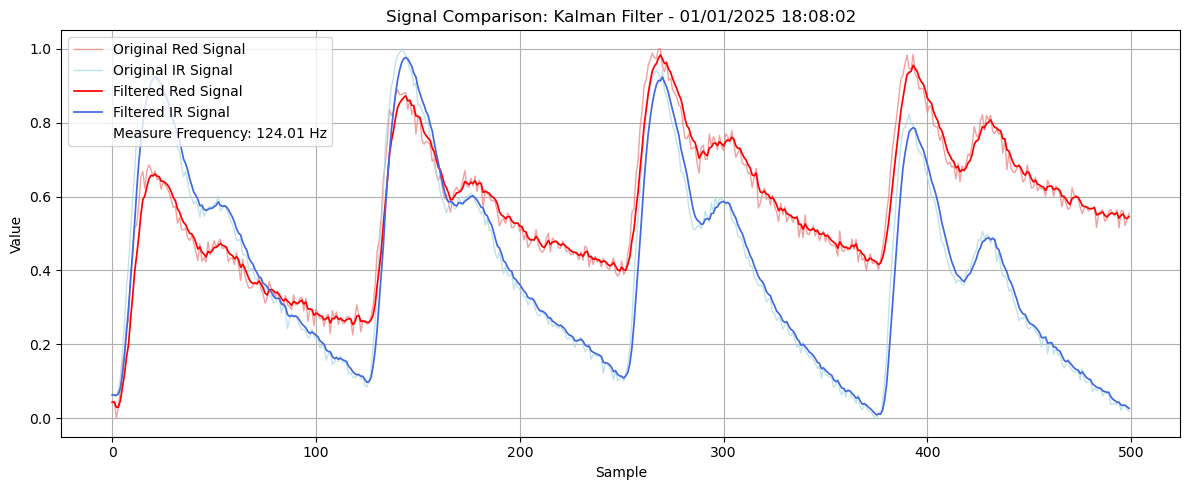

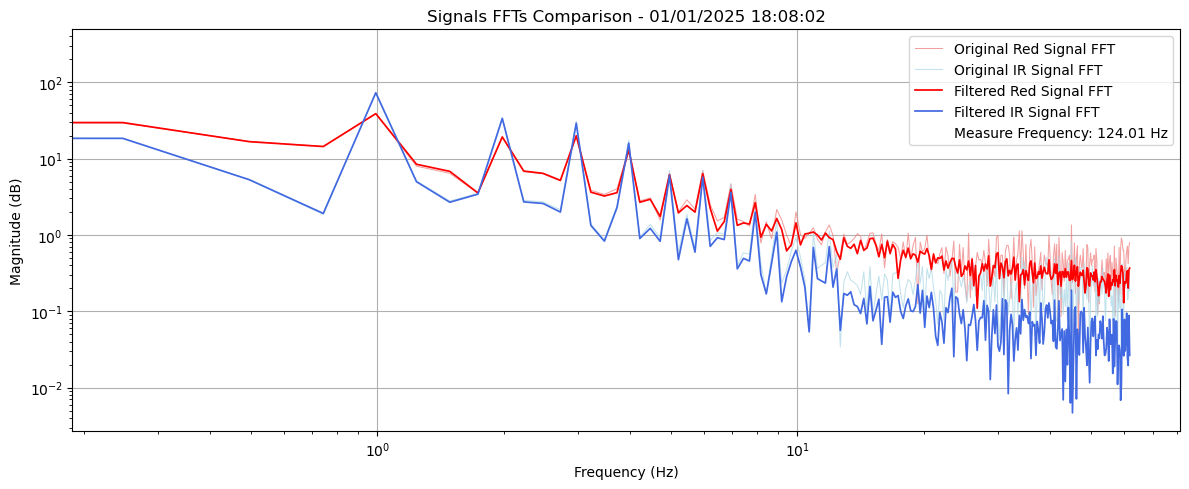

In [269]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = kalman_filter(redSignal, 0.1, 0.5)
irFilteredSignal = kalman_filter(irSignal, 0.1, 0.5)

plot_signal_compariston("Kalman Filter", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

### Bilateral Filter (for 1D)

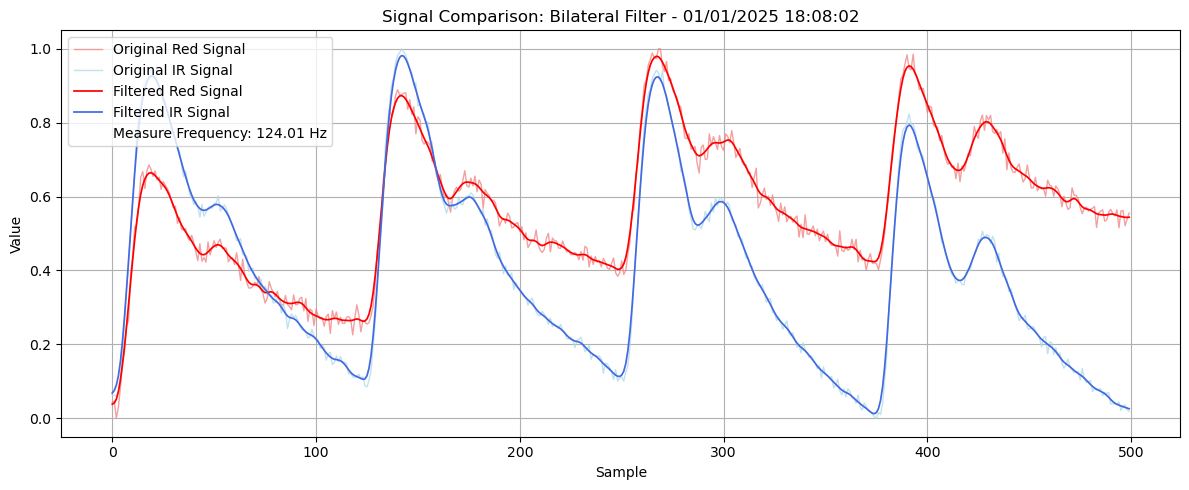

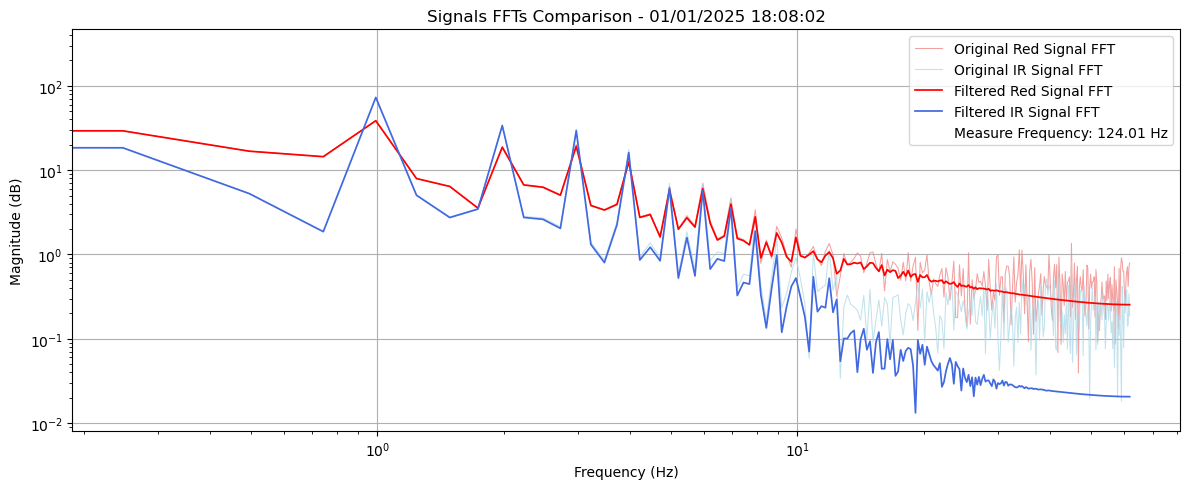

In [270]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redFilteredSignal = bilateral_filter(redSignal, 2, 10)
irFilteredSignal = bilateral_filter(irSignal, 2, 10)

plot_signal_compariston("Bilateral Filter", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

plot_fft(1, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)

## Zero Pad Test

Energy of interpolated signals
Original Red Signal %: 99.583404
Original IR Signal %: 99.895903
Filtered Red Signal %: 100.000000
Filtered IR Signal %: 100.000000


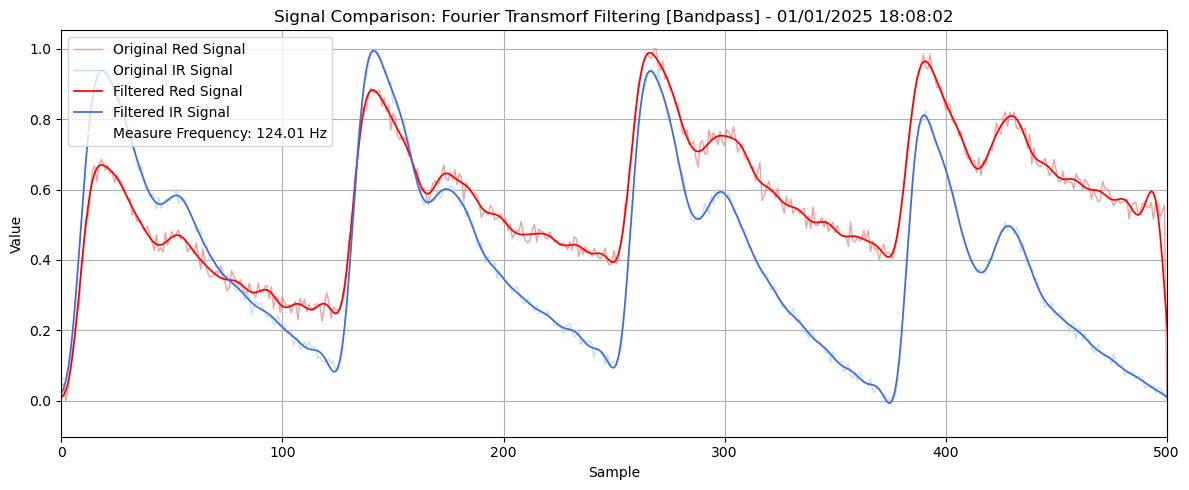

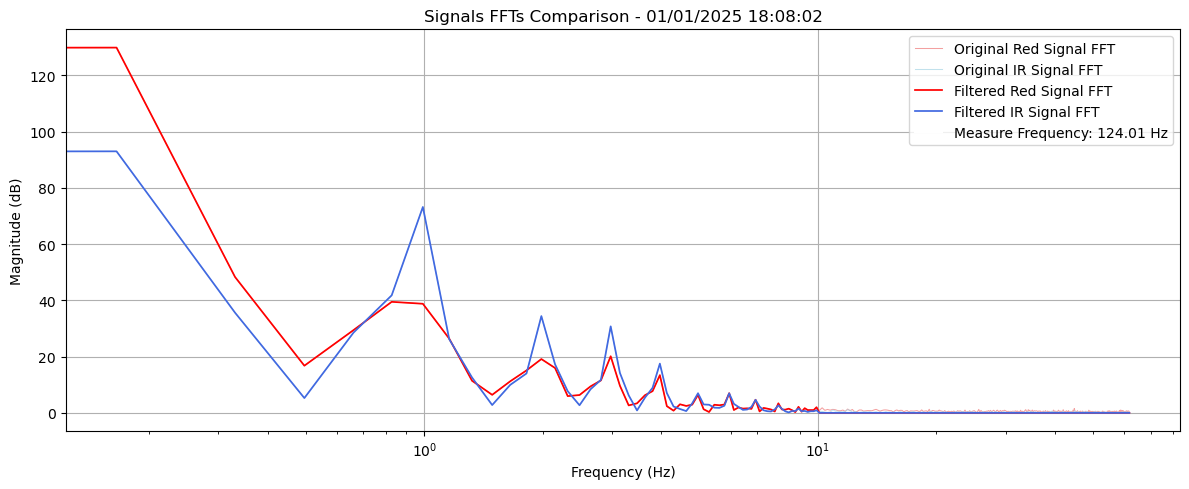

Frequency resolution: 0.1653509707702155 Hz


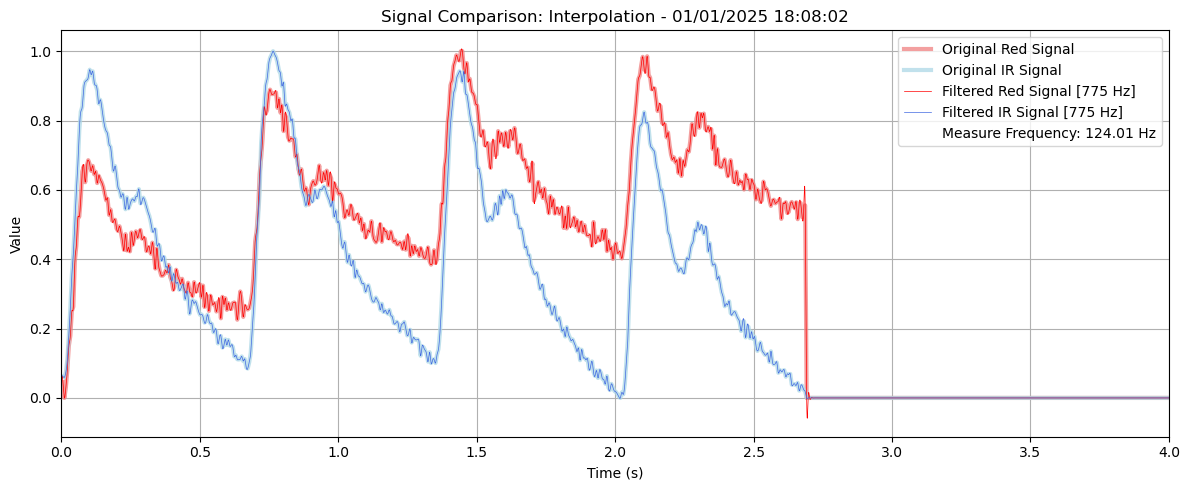

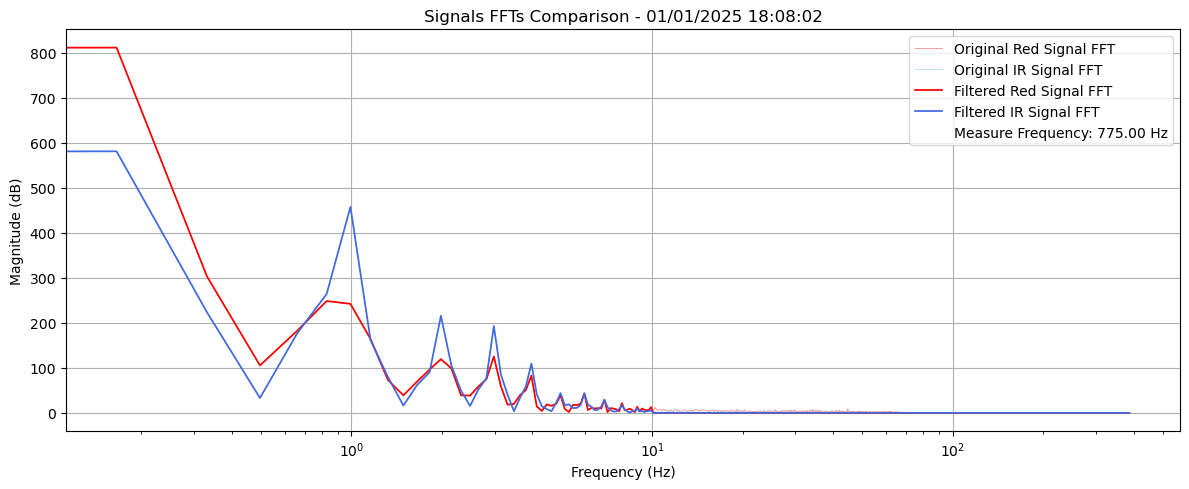

In [503]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Zero Pad Length
zero_pad = 750

# Filter Parameters
lpf = 0.1
hpf = 10

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = zero_pad_signal(np.array(parsed_signals.get("redMeasure", [])), zero_pad)
irSignal = zero_pad_signal(np.array(parsed_signals.get("irMeasure", [])), zero_pad)
redFilteredSignal = fourier_bandpass_filter(redSignal, measureFrequency, lpf, hpf)
irFilteredSignal = fourier_bandpass_filter(irSignal, measureFrequency, lpf, hpf)

# Interpolated Signals
target_freq = 775
redSignalInterpolated, target_time = interpolate_signal(redSignal, measureFrequency, target_freq)
irSignalInterpolated , target_time = interpolate_signal(irSignal,  measureFrequency, target_freq)
redFilteredSignalInterpolated = fourier_bandpass_filter(redSignalInterpolated, target_freq, lpf, hpf)
irFilteredSignalInterpolated = fourier_bandpass_filter(irSignalInterpolated, target_freq, lpf, hpf)

# Calculate the energy per frequency range of the signals
red_freqs, red_fft = compute_fft(redSignalInterpolated, target_freq)
ir_freqs, ir_fft = compute_fft(irSignalInterpolated, target_freq)
filtered_red_freqs, filtered_red_fft = compute_fft(redFilteredSignalInterpolated, target_freq)
filtered_ir_freqs, filtered_ir_fft = compute_fft(irFilteredSignalInterpolated, target_freq)

red_energy_percentage = calculate_energy_percentage(red_freqs, red_fft, 0.1, 10)
ir_energy_percentage = calculate_energy_percentage(ir_freqs, ir_fft, 0.1, 10)
red_filtered_energy_percentage = calculate_energy_percentage(filtered_red_freqs, filtered_red_fft, 0.1, 10)
ir_filtered_energy_percentage = calculate_energy_percentage(filtered_ir_freqs, filtered_ir_fft, 0.1, 10)

print(f'Energy of interpolated signals')
print(f'Original Red Signal %: {red_energy_percentage:.6f}')
print(f'Original IR Signal %: {ir_energy_percentage:.6f}')
print(f'Filtered Red Signal %: {red_filtered_energy_percentage:.6f}')
print(f'Filtered IR Signal %: {ir_filtered_energy_percentage:.6f}')

# Plots
plot_signal_compariston("Fourier Transmorf Filtering [Bandpass]", redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp, 0, 500)
plot_fft(2, redSignal, irSignal, redFilteredSignal, irFilteredSignal, measureFrequency, timestamp)


freq_resolution = target_freq / len(irFilteredSignalInterpolated)
print(f"Frequency resolution: {freq_resolution} Hz")

#plot_signal_compariston("Fourier Transmorf Filtering", redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp)
plot_interp_signal_compariston("Interpolation", redSignal, irSignal, redSignalInterpolated, irSignalInterpolated, measureFrequency, target_freq, measureTime, timestamp, 0, 4)
plot_fft(2, redSignalInterpolated, irSignalInterpolated, redFilteredSignalInterpolated, irFilteredSignalInterpolated, target_freq, timestamp)

## 800 Hz / 4 amostras por medida

### Visualização do sinal

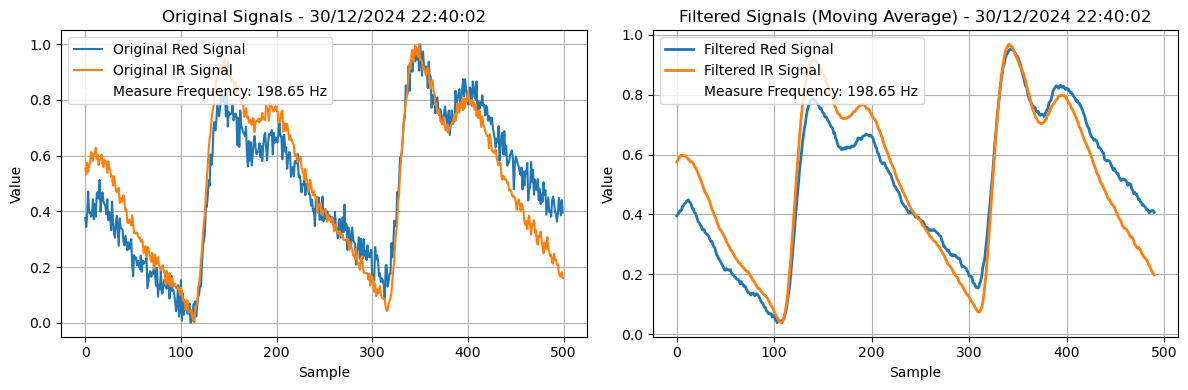

In [19]:
# Path to the CSV file
data_file = SAMPLES4_FREQ800

# Read the last signal from the file
measure = read_last_measure(data_file)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redMeasureMAF = moving_average(redSignal, 10)
irMeasureMAF = moving_average(irSignal, 10)
measureTime = measure.get("measureTime", 0)
measureFrequency = measure.get("measureFrequency", 0)
timestamp = measure.get("timestamp", "")

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, timestamp, redMeasureMAF, irMeasureMAF)

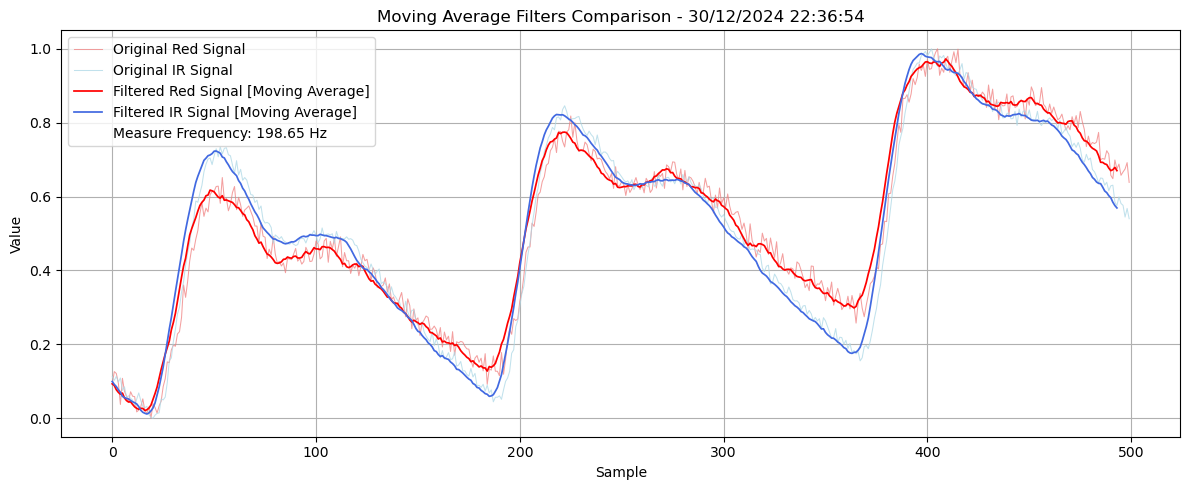

In [20]:
# Path to the CSV file
data_file = SAMPLES4_FREQ800

# Read the last signal from the file
measure = read_measure(data_file, 10)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
redSignal = np.array(parsed_signals.get("redMeasure", []))
irSignal = np.array(parsed_signals.get("irMeasure", []))
redMeasureMAF = moving_average(redSignal, 7)
irMeasureMAF = moving_average(irSignal, 7)


plot_original_maf(redSignal, irSignal, measureFrequency, timestamp, redMeasureMAF, irMeasureMAF)

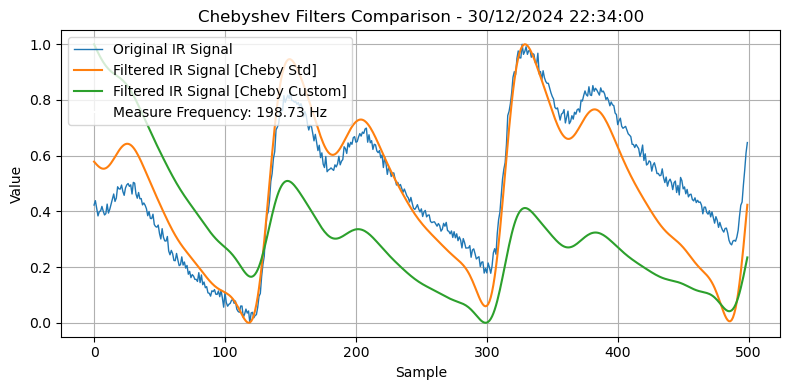

In [21]:
# Path to the CSV file
data_file = SAMPLES4_FREQ800

# Read the signal from the argument
measure = read_measure(data_file, 2)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
irSignal = np.array(parsed_signals.get("irMeasure", []))
measureTime = measure.get("measureTime", 0)
measureFrequency = measure.get("measureFrequency", 0)
timestamp = measure.get("timestamp", "")

irSignalStd = normalize(chebyshev_filter_std(irSignal, measureTime, lowcut=0.01, highcut=15.0, order=4, attenuation=40))
irSignalCustom = normalize(chebyshev_filter_custom(irSignal, measureTime, 0.00745, 12, 5, 40))


plot_original_cheby_comp(irSignal, measureFrequency, timestamp, irSignalStd, irSignalCustom)

## 1000 Hz / 8 amostras por medida

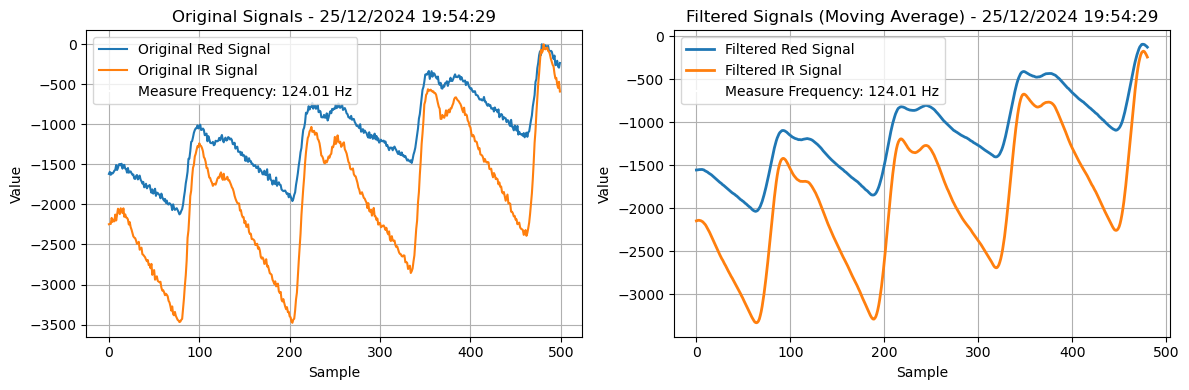

In [13]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1000

# Read the last signal from the file
measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

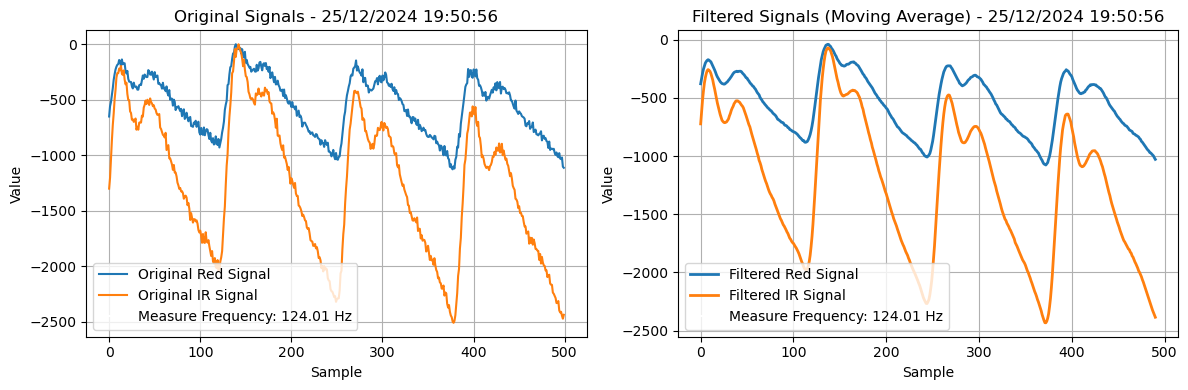

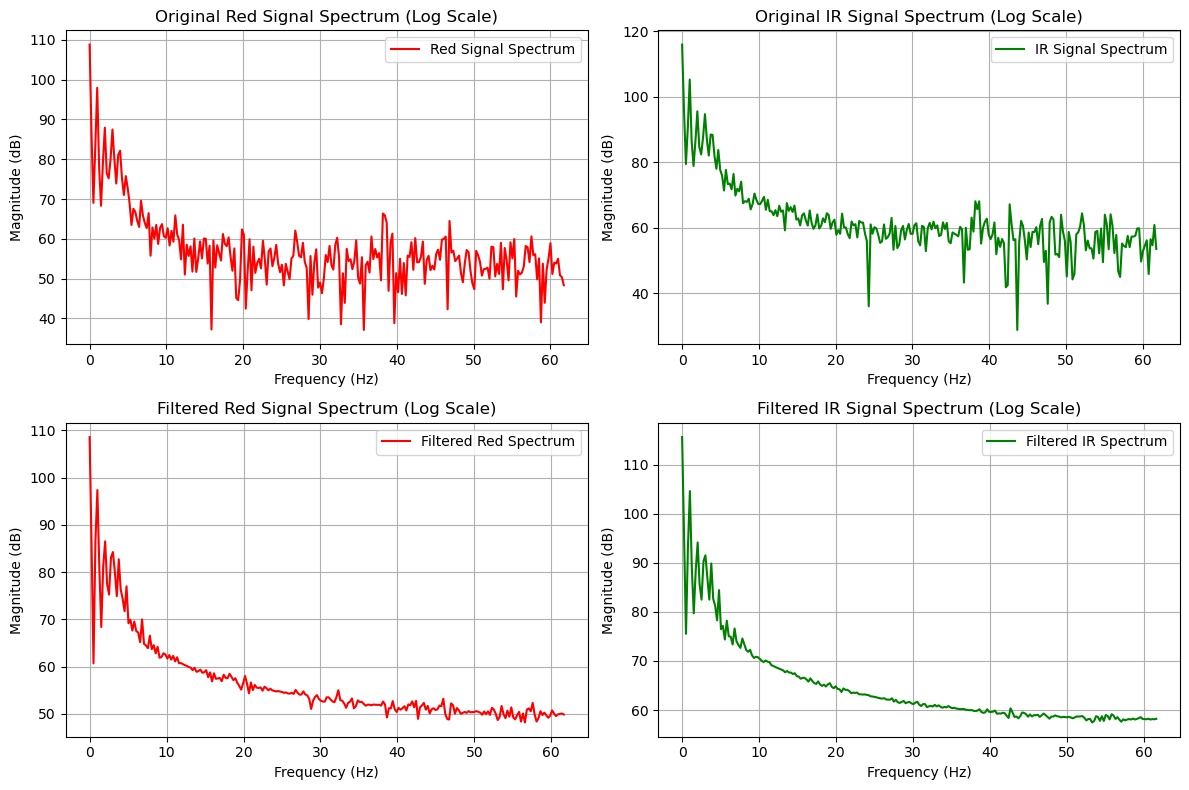

In [12]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1000

# Read the file and choose measure
data = read_file(data_file)
measure = data[-8].strip()  # Remove leading/trailing whitespace

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 10  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

# Perform FFT on the original and filtered signals

# FFT for original signals
red_freqs, red_fft = compute_fft_in_db(redSignal, measureFrequency)
ir_freqs, ir_fft = compute_fft_in_db(irSignal, measureFrequency)

# FFT for filtered signals
filtered_red_freqs, filtered_red_fft = compute_fft_in_db(filtered_red_signal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft = compute_fft_in_db(filtered_ir_signal, measureFrequency)

# FFT in dB for original signals
red_freqs, red_fft_db = compute_fft_in_db(redSignal, measureFrequency)
ir_freqs, ir_fft_db = compute_fft_in_db(irSignal, measureFrequency)

# FFT in dB for filtered signals
filtered_red_freqs, filtered_red_fft_db = compute_fft_in_db(filtered_red_signal, measureFrequency)
filtered_ir_freqs, filtered_ir_fft_db = compute_fft_in_db(filtered_ir_signal, measureFrequency)

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

# Plot the spectral analysis with logarithmic magnitude scale
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Plot original signals' spectra
plt.subplot(2, 2, 1)
plt.plot(red_freqs, red_fft_db, label='Red Signal Spectrum', color='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Original Red Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ir_freqs, ir_fft_db, label='IR Signal Spectrum', color='g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Original IR Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

# Plot filtered signals' spectra
plt.subplot(2, 2, 3)
plt.plot(filtered_red_freqs, filtered_red_fft_db, label='Filtered Red Spectrum', color='r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filtered Red Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(filtered_ir_freqs, filtered_ir_fft_db, label='Filtered IR Spectrum', color='g')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Filtered IR Signal Spectrum (Log Scale)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## 1600 Hz / 8 amostras por medida

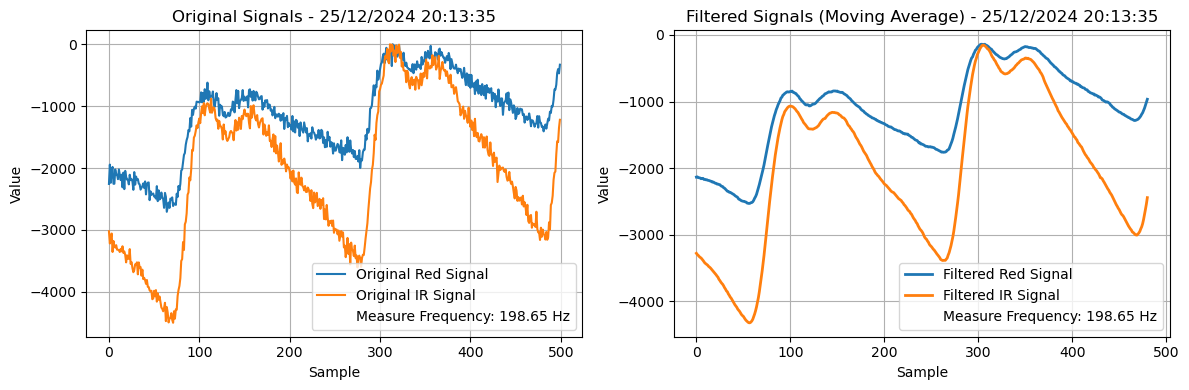

In [11]:
# Path to the CSV file
data_file = SAMPLES8_FREQ1600

# Read the last signal from the file
measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

## 1600 Hz / 16amostras por medida

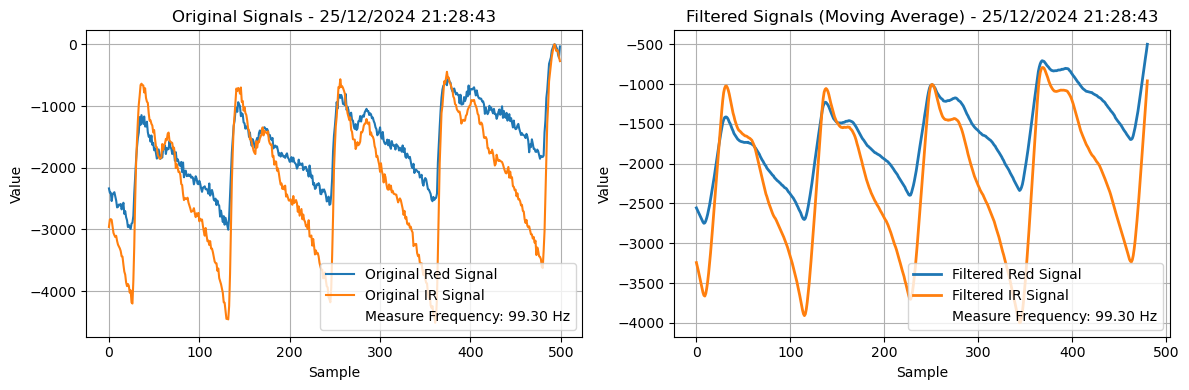

In [10]:
# Path to the CSV file
data_file = SAMPLES16_FREQ1600

# Read the last signal from the file
measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 20  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

# Heart Rate and Pulse Detection

In [557]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 42)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
measureTime = measure.get("measureTime", 0)
timestamp = measure.get("timestamp", "")
measureFrequency = measure.get("measureFrequency", 0)
irSignal = np.array(parsed_signals.get("irMeasure", []))
irFilteredSignal = fourier_bandpass_filter(irSignal, measureFrequency) # args: signal, fs, lf, hf

Heart Rate: 59.524


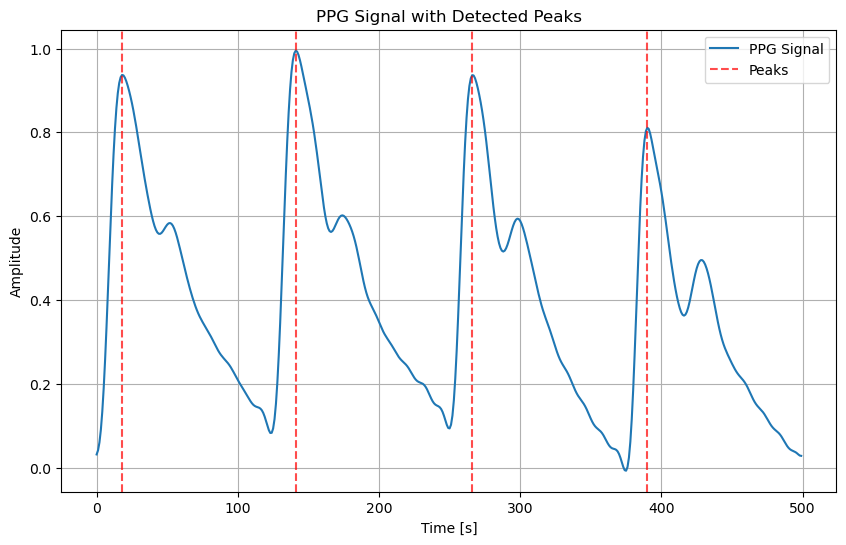

In [558]:
# Calculating the peaks
distance = int(measureFrequency * 0.3)  # Minimum distance between peaks (e.g., 0.3 seconds for HR ~200 BPM)
prominence = 0.7  # Adjust based on signal amplitude
peaks = detect_peaks(irFilteredSignal, distance, prominence)
peaks_times = np.array(peaks) / measureFrequency  # Convert sample indices to time

# Calculating the Heart Rate
heart_rate = len(peaks) * 60 / (len(irFilteredSignal) / measureFrequency)  # BPM
print(f'Heart Rate: {heart_rate:.3f}')

# Detecting Pulse Onset and Offset
onsets, offsets = detect_onset_offset(irFilteredSignal, peaks)

# Detecting Signal Phases
phases = compute_phases(irFilteredSignal, onsets, offsets, peaks)

# Detecting Dicrotic Notches
notches = detect_dicrotic_notch(irFilteredSignal, peaks, offsets)

# Plot the signal
x_axis = np.linspace(0, measureTime, len(irFilteredSignal)) # Get a timebased array for plotting
plt.figure(figsize=(10, 6))
plt.plot(irFilteredSignal, label="PPG Signal", linewidth=1.5)

# Add vertical lines at peaks
for peak in peaks:
    plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7, label="Peaks" if 'Peaks' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add labels and legend
plt.title("PPG Signal with Detected Peaks")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

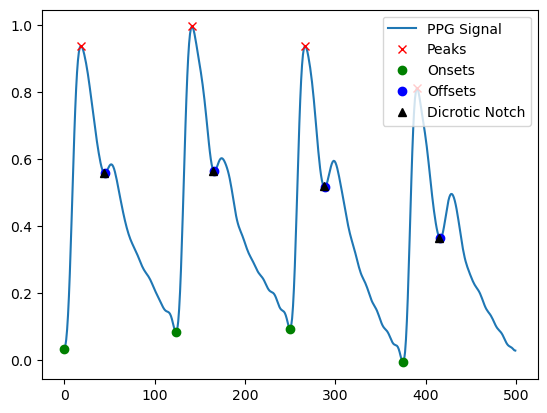

In [559]:
plt.plot(irFilteredSignal, label="PPG Signal")
plt.plot(peaks, irFilteredSignal[peaks], 'rx', label="Peaks")
plt.plot(onsets, irFilteredSignal[onsets], 'go', label="Onsets")
plt.plot(offsets, irFilteredSignal[offsets], 'bo', label="Offsets")
plt.plot(notches, irFilteredSignal[notches], 'k^', label="Dicrotic Notch")
plt.legend()
plt.show()

# SQA - Signal Quality Assessment

## Definindo parâmetros do sensor

In [66]:
# Paths to the CSV files
data_file1 = SAMPLES4_FREQ800
data_file2 = SAMPLES8_FREQ1000
data_file3 = SAMPLES8_FREQ1600
data_file4 = SAMPLES16_FREQ1600

# Define the window size for the moving average filter
window_size = 10

# Setting the list of files to be analyzed
file_list = [SAMPLES4_FREQ800, SAMPLES8_FREQ1000, SAMPLES8_FREQ1600, SAMPLES16_FREQ1600]  # Replace with your file paths

# Calling the function that returns the analysis results
all_results = process_multiple_files(file_list, window_size)

# Display results
for file, indices in all_results.items():
    print(f"\nResults for {file}:")
    for key, value in indices.items():
        print(f"{key}: {value}")

Processing file: C:/Users/wgabr/TCC/CollectedData/800Hz_4samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1000Hz_8samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1600Hz_8samples.csv
Processing file: C:/Users/wgabr/TCC/CollectedData/1600Hz_16samples.csv

Results for C:/Users/wgabr/TCC/CollectedData/800Hz_4samples.csv:
red_ori_skew: -0.19216952558565506
ir_ori_skew: -0.2919933086721743
red_ori_kurt: -0.8641380728337733
ir_ori_kurt: -0.8632775362725867
red_mov_skew: -0.1826449833410143
ir_mov_skew: -0.28050666713931777
red_mov_kurt: -0.909396270968567
ir_mov_kurt: -0.8931326819923318
red_cheby_skew: 1.4686312588304946
ir_cheby_skew: 1.0504904185562665
red_cheby_kurt: 4.694118956205594
ir_cheby_kurt: 4.724103929089663

Results for C:/Users/wgabr/TCC/CollectedData/1000Hz_8samples.csv:
red_ori_skew: -0.09935092296351569
ir_ori_skew: -0.0785450320413821
red_ori_kurt: -0.8282710235307041
ir_ori_kurt: -0.8978453939728641
red_mov_skew: -0.11066693470396305
ir_mov_skew:

Red: Skewness -0.325057 ; Kurtosis -0.728046
IR: Skewness -0.377 ; Kurtosis -0.855


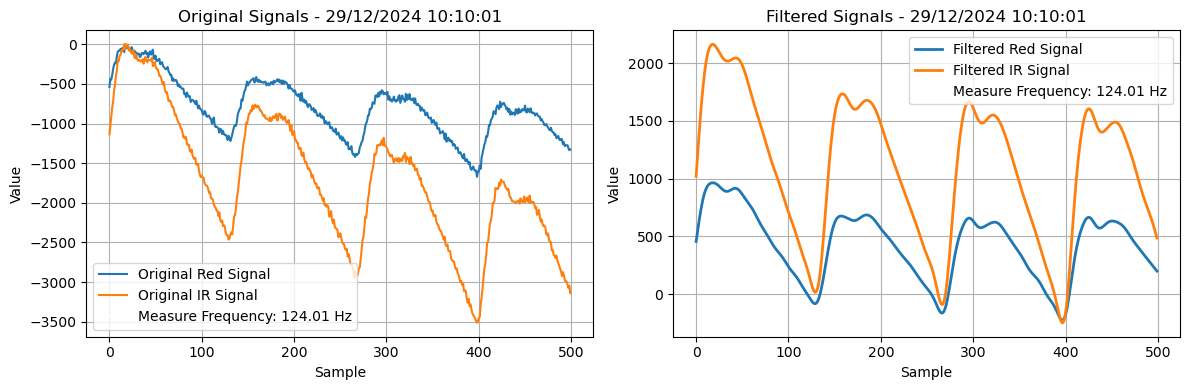

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta

# Path to the CSV file
data_file = 'C:/Users/wgabr/Jupyter Notebooks/TCC/CollectedData/red_ir_comparison.csv'

# Read the data from the CSV file
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract the last line (most recent data)
last_line = data[-1].strip()  # Remove leading/trailing whitespace

# Parse the line into components: timestamp, redMeasure, and irMeasure
try:
    timestamp, measureTime, red_measure_str, ir_measure_str = last_line.split(';')
    redSignal = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
    irSignal = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
except ValueError as e:
    print(f"Error parsing line: {last_line}")
    raise e

# Convert timestamp to datetime object (assuming it's in UTC)
dt = datetime.utcfromtimestamp(int(timestamp))

# Adjust for the time zone by subtracting 3 hours
dt_adjusted = dt - timedelta(hours=3)

# Format the datetime as day/month/year hour:minute:second
formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")

# Adjust the measure time to seconds
measureTime = int(measureTime)/1000

# Convert both signals to numpy arrays for easier processing
red_signal = np.array(redSignal)
ir_signal = np.array(irSignal)

# Multiply both signals by -1 to invert them
red_signal = -red_signal
ir_signal = -ir_signal

# Design a 4th order Chebyshev-II bandpass filter
num_values = len(red_signal)  # Assuming both signals have the same length
fs = num_values / measureTime
lowcut = 0.01  # Low cut frequency in Hz
highcut = 15.0  # High cut frequency in Hz
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Calculate the frequency
measureFrequency = (num_values/measureTime)

# Create the filter coefficients for the bandpass filter
b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to both signals (Red and IR)
filtered_red_signal = filtfilt(b, a, red_signal)
filtered_ir_signal = filtfilt(b, a, ir_signal)

red_skew = skew(filtered_red_signal)
red_kurt = kurtosis(filtered_red_signal, fisher = True)
ir_skew = skew(filtered_ir_signal)
ir_kurt = kurtosis(filtered_ir_signal, fisher = True)
print(f"Red: Skewness {red_skew:3f} ; Kurtosis {red_kurt:3f}")
print(f"IR: Skewness {ir_skew:.3f} ; Kurtosis {ir_kurt:.3f}")

# Create a figure with two subplots arranged side by side
plt.figure(figsize=(12, 4))  # Adjust figure size as needed

# Plot the original signals on the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(red_signal, label='Original Red Signal')
plt.plot(ir_signal, label='Original IR Signal')
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Original Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Plot the filtered signals on the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(filtered_red_signal, label='Filtered Red Signal', linewidth=2)
plt.plot(filtered_ir_signal, label='Filtered IR Signal', linewidth=2)
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Filtered Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()

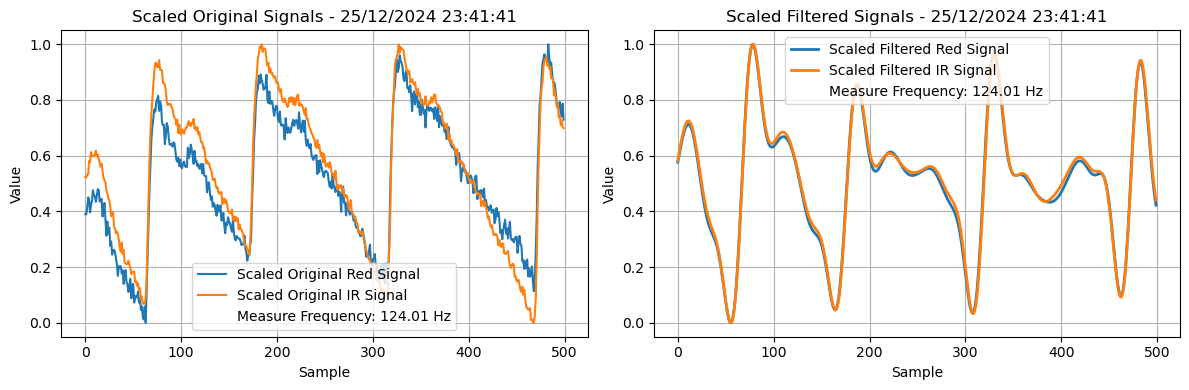

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt
import ast  # To safely parse the string representation of lists
from datetime import datetime, timedelta

# Path to the CSV file
data_file = 'C:/Users/wgabr/TCC/CollectedData/red_ir_comparison.csv'

# Read the data from the CSV file
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract the last line (most recent data)
last_line = data[-1].strip()  # Remove leading/trailing whitespace

# Parse the line into components: timestamp, redMeasure, and irMeasure
try:
    timestamp, measureTime, red_measure_str, ir_measure_str = last_line.split(';')
    redSignal = ast.literal_eval(red_measure_str)  # Convert the string representation of list to a list
    irSignal = ast.literal_eval(ir_measure_str)    # Convert the string representation of list to a list
except ValueError as e:
    print(f"Error parsing line: {last_line}")
    raise e

# Convert timestamp to datetime object (assuming it's in UTC)
dt = datetime.utcfromtimestamp(int(timestamp))

# Adjust for the time zone by subtracting 3 hours
dt_adjusted = dt - timedelta(hours=3)

# Format the datetime as day/month/year hour:minute:second
formatted_datetime = dt_adjusted.strftime("%d/%m/%Y %H:%M:%S")

# Adjust the measure time to seconds
measureTime = int(measureTime)/1000

# Convert both signals to numpy arrays for easier processing
red_signal = np.array(redSignal)
ir_signal = np.array(irSignal)

# Multiply both signals by -1 to invert them
red_signal = -red_signal
ir_signal = -ir_signal

# 4th order Chebyshev-II bandpass filter
num_values = len(red_signal)
fs = num_values / measureTime
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
red_filtered_signal = filtfilt(b, a, red_signal)
ir_filtered_signal = filtfilt(b, a, ir_signal)

# Scale the filtered signal between 0 and 1
red_scaled_signal = (red_signal - np.min(red_signal)) / (np.max(red_signal) - np.min(red_signal))
ir_scaled_signal = (ir_signal - np.min(ir_signal)) / (np.max(ir_signal) - np.min(ir_signal))
red_scaled_filtered_signal = (red_filtered_signal - np.min(red_filtered_signal)) / (np.max(red_filtered_signal) - np.min(red_filtered_signal))
ir_scaled_filtered_signal = (ir_filtered_signal - np.min(ir_filtered_signal)) / (np.max(ir_filtered_signal) - np.min(ir_filtered_signal))

# Create a figure with two subplots arranged side by side
plt.figure(figsize=(12, 4))  # Adjust figure size as needed

# Plot the original signals on the first subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(red_scaled_signal, label='Scaled Original Red Signal')
plt.plot(ir_scaled_signal, label='Scaled Original IR Signal')
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f'Scaled Original Signals - {formatted_datetime}')
plt.legend()
plt.grid(True)

# Plot the filtered signals on the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(red_scaled_filtered_signal, label='Scaled Filtered Red Signal', linewidth=2)
plt.plot(ir_scaled_filtered_signal, label='Scaled Filtered IR Signal', linewidth=2)
plt.plot([], label=f'Measure Frequency: {measureFrequency:.2f} Hz', color='white')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title(f"Scaled Filtered Signals - {formatted_datetime}")
plt.legend()
plt.grid(True)

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()


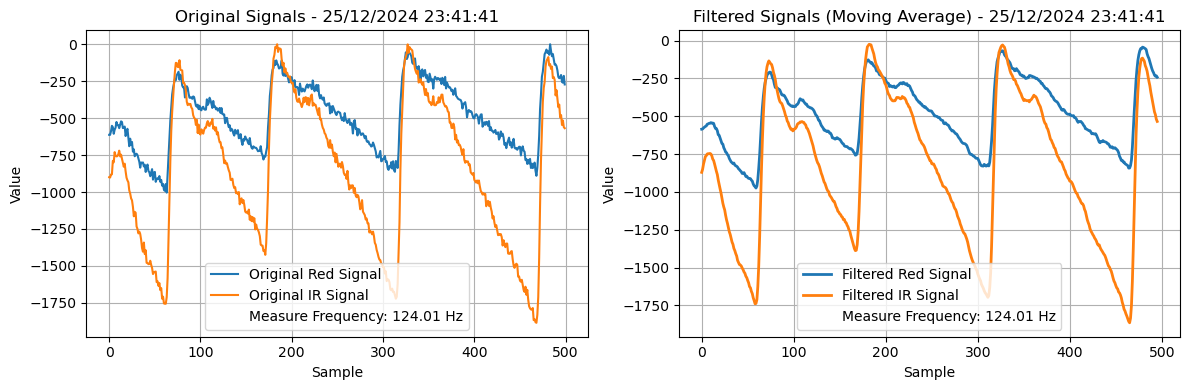

In [194]:
# Path to the CSV file
data_file = 'C:/Users/wgabr/TCC/CollectedData/red_ir_comparison.csv'

# Read the last signal from the file
measure = read_last_measure(data_file)

# Get the parsed features from the measure
timestamp, measureTime, redSignal, irSignal = parse_measure(measure)

# get the parsed datetime, measure time and measure frequency
formatted_datetime, measureTime, measureFrequency = time_manager(timestamp, measureTime, irSignal)

# Define the window size for the moving average filter
window_size = 5  # Adjust the size as needed for your data and smoothing level

# Apply the moving average filter to both signals
filtered_red_signal = moving_average(redSignal, window_size)
filtered_ir_signal = moving_average(irSignal, window_size)

# Adjust the time axis for the filtered signals
# Convolution with 'valid' reduces the length by (window_size - 1)
filtered_time_axis = np.arange(len(filtered_red_signal))

plot_original_movingAverage_red_ir(redSignal, irSignal, measureFrequency, formatted_datetime, filtered_time_axis, filtered_red_signal, filtered_ir_signal)

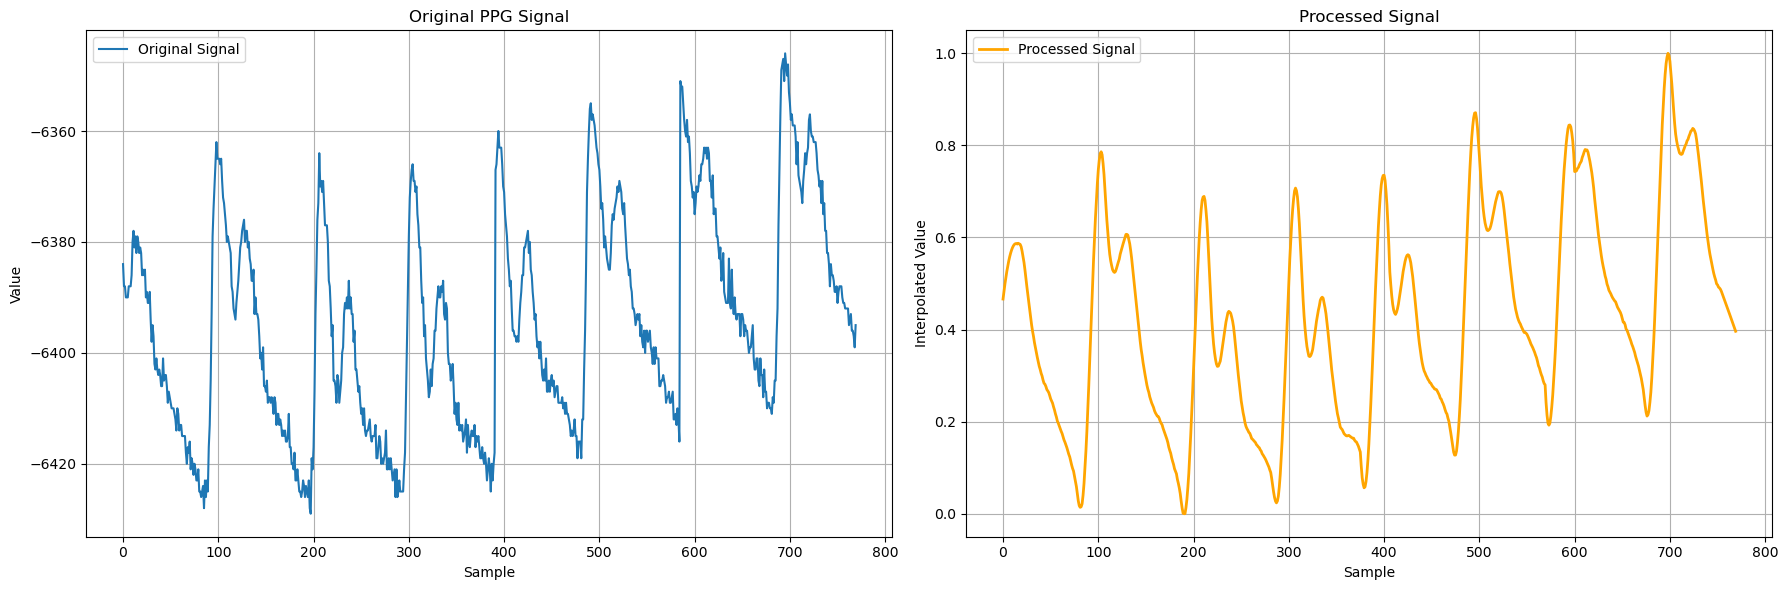

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt, savgol_filter
from scipy.interpolate import interp1d

# Read the data from the .txt file
data_file = 'sensor_data.txt'
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract values from each line
values = []
for line_num, line in enumerate(data, start=1):
    line = line.strip()
    if line:  # This check ensures that the line is not empty
        try:
            value = int(line)
            values.append(value)
        except ValueError:
            print(f"Error parsing line {line_num}: {line}")

# Convert values to a numpy array
ppg_signal = np.array(values)* -1


"""
# 4th order Chebyshev-II bandpass filter
num_values = len(ppg_signal)
fs = num_values / 4
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
filtered_signal = filtfilt(b, a, ppg_signal)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
"""

#"""
# Apply the Savitzky-Golay filter to the PPG signal
# window_length must be less than or equal to num_values and should be odd
# polyorder is the order of the polynomial used to fit the samples
window_length = 31  # Adjust as needed
polyorder = 2  # Adjust as needed

filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))

# Prepare the data for the model
scaled_signal = np.array(scaled_signal, dtype=np.float32)
#"""


# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original signal
ax1.plot(ppg_signal, label='Original Signal')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Value')
ax1.set_title('Original PPG Signal')
ax1.legend()
ax1.grid(True)
#ax1.set_ylim(19500, 21000)

# Processed Signal
ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Interpolated Value')
ax2.set_title(f'Processed Signal')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

Skewness Signal Quality Index (SSQI) Filtered: 1.0442652493156137
Skewness Signal Quality Index (SSQI) Original: 0.46634274029872863


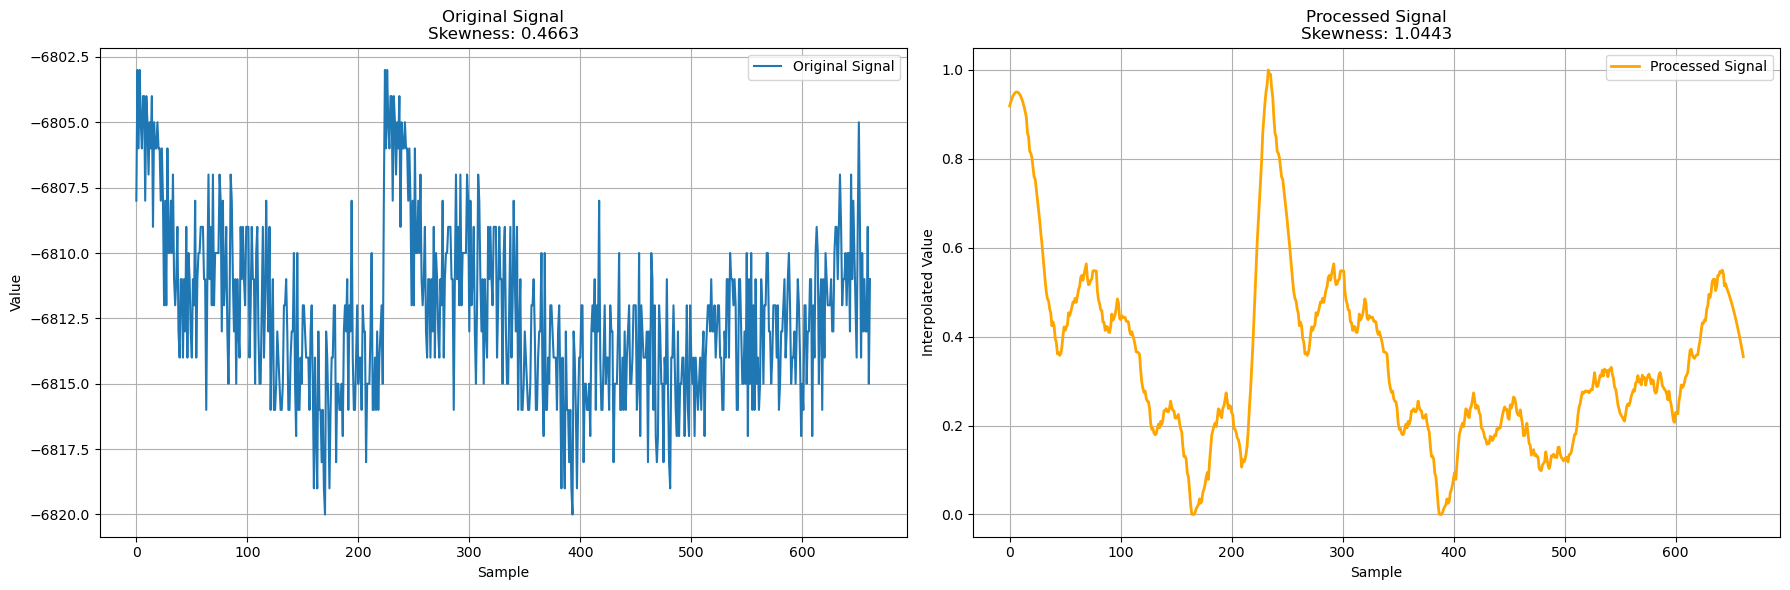

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import cheby2, filtfilt, savgol_filter
from scipy.interpolate import interp1d
from scipy.stats import skew

# Read the data from the .txt file
data_file = 'sensor_data.txt'
with open(data_file, 'r') as file:
    data = file.readlines()

# Extract values from each line
values = []
for line_num, line in enumerate(data, start=1):
    line = line.strip()
    if line:  # This check ensures that the line is not empty
        try:
            value = int(line)
            values.append(value)
        except ValueError:
            print(f"Error parsing line {line_num}: {line}")

# Convert values to a numpy array
ppg_signal = np.array(values)* -1

""""
# Apply the Savitzky-Golay filter to the PPG signal
# window_length must be less than or equal to num_values and should be odd
# polyorder is the order of the polynomial used to fit the samples
window_length = 31  # Adjust as needed
polyorder = 2  # Adjust as needed

filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)
""""

# 4th order Chebyshev-II bandpass filter
num_values = len(ppg_signal)
fs = num_values / 4
lowcut = 0.5
highcut = 8.0
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

b, a = cheby2(4, 40, [low, high], btype='bandpass')

# Apply the filter to the PPG signal
filtered_signal = filtfilt(b, a, ppg_signal)

# Scale the filtered signal between 0 and 1
scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))

# Prepare the data for the model
scaled_signal = np.array(scaled_signal, dtype=np.float32)

# Calculate skewness
ssqi_original = skew(ppg_signal)
ssqi_filtered = skew(scaled_signal)

# Print skewness
print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Original signal
ax1.plot(ppg_signal, label='Original Signal')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Value')
ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
ax1.legend()
ax1.grid(True)

# Processed Signal
ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Interpolated Value')
ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

621
Datetime: 2024-08-19T21:27:30.869Z
Skewness Signal Quality Index (SSQI) Filtered: -0.2301360055446394
Skewness Signal Quality Index (SSQI) Original: -0.1610213144256207


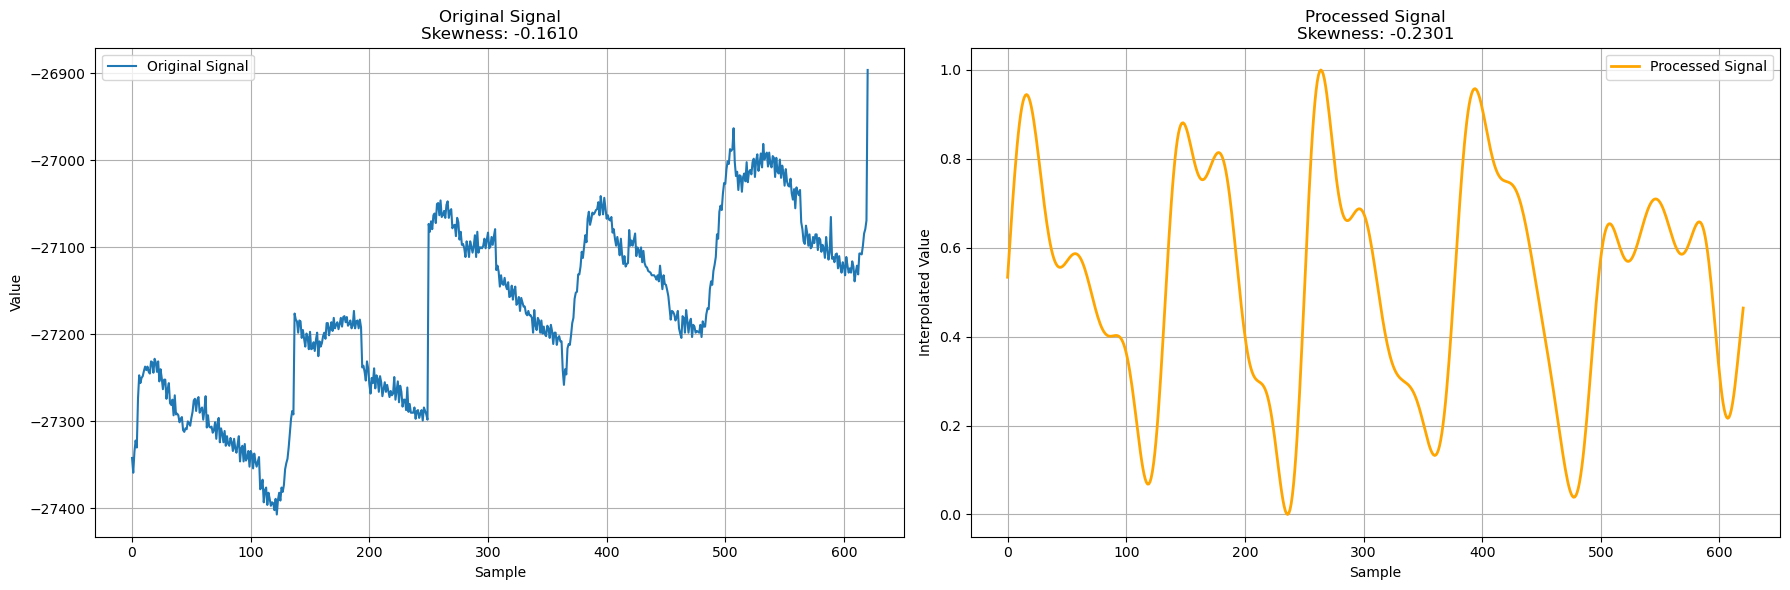

In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter, cheby2,filtfilt
from scipy.stats import skew

# Read the data from the CSV file
data_file = 'C:/Users/wgabr/Python Codes/SmartBP/Computing/measures.csv'
df = pd.read_csv(data_file)

# Function to process and plot a specific measure by index
def process_and_plot_measure(index):
    # Extract the datetime and values string
    datetime = df.iloc[index, 0]
    values_string = df.iloc[index, 1].strip('"')

    # Convert the values string to a list of integers, handling any empty or invalid values
    try:
        values = [int(v) for v in values_string.split(',') if v.strip().isdigit()]
    except ValueError as e:
        print(f"Error parsing values on row {index + 1}: {e}")
        return

    # Convert values to a numpy array and apply any necessary transformations
    ppg_signal = np.array(values) * -1
    print(len(ppg_signal))

    """
    # Apply the Savitzky-Golay filter to the PPG signal
    window_length = 31  # Adjust as needed
    polyorder = 2  # Adjust as needed
    filtered_signal = savgol_filter(ppg_signal, window_length, polyorder)

    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    """

    # 4th order Chebyshev-II bandpass filter
    num_values = len(ppg_signal)
    fs = num_values / 4
    lowcut = 0.5
    highcut = 8.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = cheby2(4, 40, [low, high], btype='bandpass')
    
    # Apply the filter to the PPG signal
    filtered_signal = filtfilt(b, a, ppg_signal)
    
    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    
    # Prepare the data for the model
    scaled_signal = np.array(scaled_signal, dtype=np.float32)

    # Calculate skewness
    ssqi_original = skew(ppg_signal)
    ssqi_filtered = skew(scaled_signal)

    # Print skewness
    print(f'Datetime: {datetime}')
    print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
    print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Original signal
    ax1.plot(ppg_signal, label='Original Signal')
    ax1.set_xlabel('Sample')
    ax1.set_ylabel('Value')
    ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
    ax1.legend()
    ax1.grid(True)

    # Processed Signal
    ax2.plot(scaled_signal, label='Processed Signal', linewidth=2, color='orange')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Interpolated Value')
    ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
    ax2.legend()
    ax2.grid(True)

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

# Example usage: process and plot the measure at index 0
process_and_plot_measure(-1)

400
Datetime: 2024-09-05T09:59:16.048Z
Skewness Signal Quality Index (SSQI) Filtered: 0.8602363643543105
Skewness Signal Quality Index (SSQI) Original: 0.6901732159896712


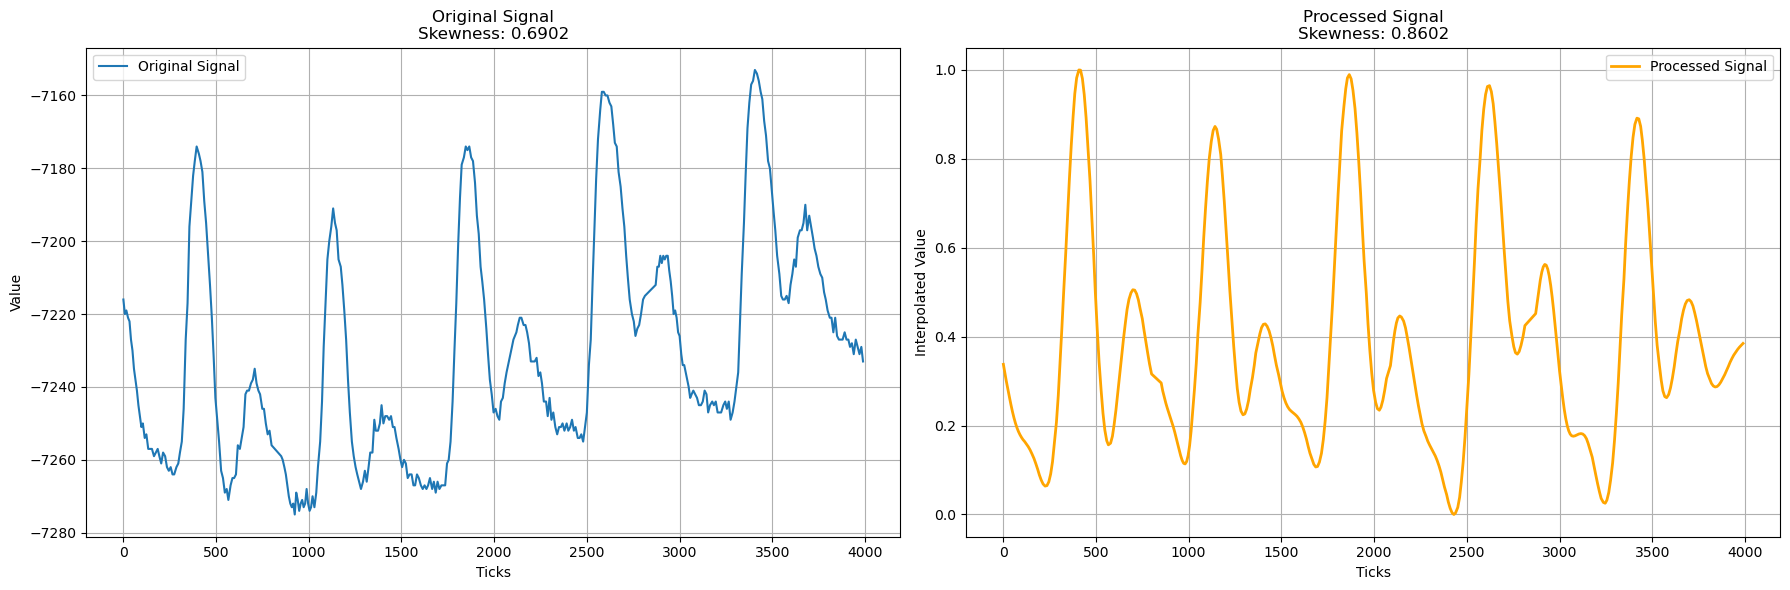

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import cheby2, filtfilt
from scipy.stats import skew

# Read the data from the CSV file
data_file = 'C:/Users/wgabr/Python Codes/SmartBP/Computing/measures_ticks.csv'
df = pd.read_csv(data_file)

# Function to process and plot a specific measure by index
def process_and_plot_measure(index):
    # Extract the datetime and values strings
    datetime = df.iloc[index, 0]
    values_string = df.iloc[index, 1].strip('"')
    ticks_string = df.iloc[index, 2].strip('"')

    # Convert the values string to a list of integers
    try:
        values = [int(v) for v in values_string.split(',') if v.strip().isdigit()]
        ticks = [int(t) for t in ticks_string.split(',') if t.strip().isdigit()]
    except ValueError as e:
        print(f"Error parsing values or ticks on row {index + 1}: {e}")
        return

    # Convert values and ticks to numpy arrays
    ppg_signal = np.array(values) * -1
    ppg_ticks = np.array(ticks)

    # Ensure the lengths of values and ticks match
    if len(ppg_signal) != len(ppg_ticks):
        print(f"Mismatch in lengths of values and ticks on row {index + 1}")
        return

    # 4th order Chebyshev-II bandpass filter
    num_values = len(ppg_signal)
    fs = num_values / 4
    lowcut = 0.5
    highcut = 8.0
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = cheby2(4, 40, [low, high], btype='bandpass')
    
    # Apply the filter to the PPG signal
    filtered_signal = filtfilt(b, a, ppg_signal)
    
    # Scale the filtered signal between 0 and 1
    scaled_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))
    
    # Prepare the data for the model
    scaled_signal = np.array(scaled_signal, dtype=np.float32)

    # Calculate skewness
    ssqi_original = skew(ppg_signal)
    ssqi_filtered = skew(scaled_signal)

    # Print skewness
    print(len(ppg_signal))
    print(f'Datetime: {datetime}')
    print(f'Skewness Signal Quality Index (SSQI) Filtered: {ssqi_filtered}')
    print(f'Skewness Signal Quality Index (SSQI) Original: {ssqi_original}')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Original signal
    ax1.plot(ppg_ticks, ppg_signal, label='Original Signal')
    ax1.set_xlabel('Ticks')
    ax1.set_ylabel('Value')
    ax1.set_title(f'Original Signal\nSkewness: {ssqi_original:.4f}')
    ax1.legend()
    ax1.grid(True)

    # Processed Signal
    ax2.plot(ppg_ticks, scaled_signal, label='Processed Signal', linewidth=2, color='orange')
    ax2.set_xlabel('Ticks')
    ax2.set_ylabel('Interpolated Value')
    ax2.set_title(f'Processed Signal\nSkewness: {ssqi_filtered:.4f}')
    ax2.legend()
    ax2.grid(True)

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

# Example usage: process and plot the measure at index 0
process_and_plot_measure(-1)

# Neurokit2 Test

In [82]:
# Path to the CSV file
data_file = DEFAULT_PARAMS

# Read the last signal from the file
measure = read_measure(data_file, 46)

# Parse signals in the last measure
parsed_signals = get_parsed_signals(measure)

# Get the parsed features from the measure
timestamp = measure.get("timestamp", "")
measureTime = measure.get("measureTime", 0)
measureFrequency = measure.get("measureFrequency", 0)
irSignal = np.array(parsed_signals.get("irMeasure", []))
irFilteredSignal = fourier_bandpass_filter(irSignal, measureFrequency) # args: signal, fs, lf, hf

      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
0    0.537720   0.003637  58.251598     0.995548          0
1    0.539786   0.006307  58.251598     0.995548          0
2    0.542887   0.008640  58.251598     0.995548          0
3    0.527385   0.010355  58.251598     0.995548          0
4    0.540820   0.011195  58.251598     0.995548          0
..        ...        ...        ...          ...        ...
495  0.826731   0.029468  57.206056     0.995772          0
496  0.829142   0.031872  57.206056     0.995772          0
497  0.834654   0.033485  57.206056     0.995772          0
498  0.846021   0.034454  57.206056     0.995772          0
499  0.838787   0.035082  57.206056     0.995772          0

[500 rows x 5 columns]


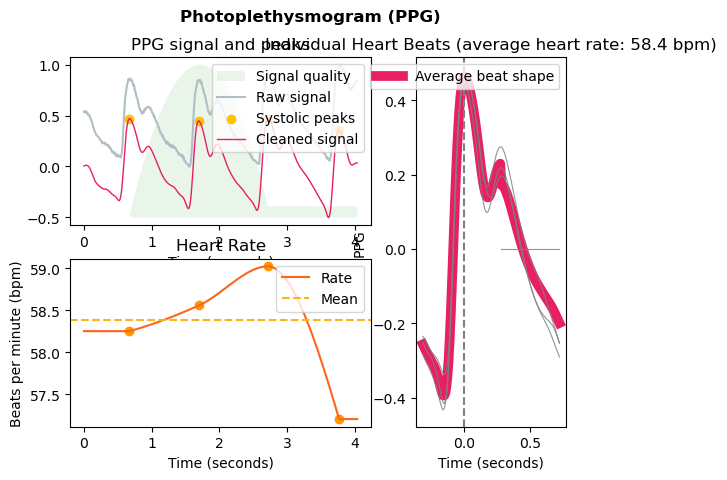

In [83]:
signals, info = nk.ppg_process(irSignal, sampling_rate=measureFrequency, static=False)

nk.ppg_plot(signals, info, static=True)

print(signals)

In [86]:

# Step 1: Preprocess the PPG signal
clean_signal = nk.ppg_clean(irSignal, sampling_rate=measureFrequency)

# Step 2: Assess signal quality
quality = nk.ppg_quality(clean_signal, sampling_rate=measureFrequency, method="templatematch", approach=None)
print("Signal Quality Indices:", quality)

# Step 4: Extract peaks and analyze features (if signal quality is good)
if all(quality == "good"):
    signals, info = nk.ppg_findpeaks(clean_signal, sampling_rate=measureFrequency)
    print("Detected peaks:", info["PPG_Peaks"])
else:
    print("Signal quality is poor, skipping feature analysis.")

Signal Quality Indices: [0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815 0.99554815
 0.99559592 0.99564333 0.99569036 0.99

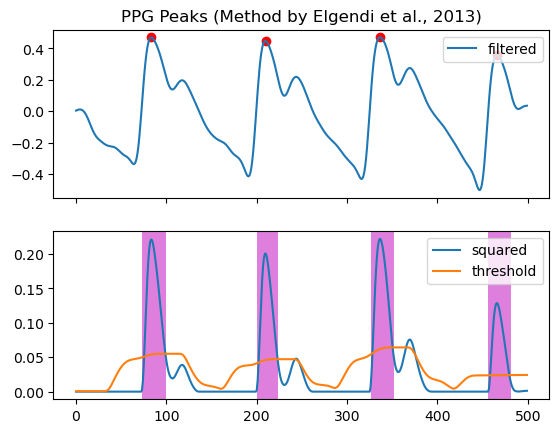

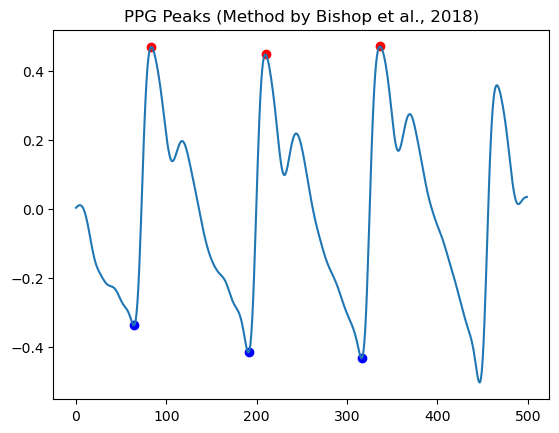

In [49]:
ppg = nk.ppg_simulate(heart_rate=75, duration=20, sampling_rate=50)

ppg_clean = nk.ppg_clean(irSignal, sampling_rate=measureFrequency)

peaks = nk.ppg_findpeaks(ppg_clean, sampling_rate=measureFrequency, show=True)

# Method by Bishop et al., (2018)
peaks = nk.ppg_findpeaks(ppg_clean, method="bishop", show=True)

Index([-0.30828635903539886, -0.30019485354890546, -0.29210334806241206,
        -0.2840118425759186,  -0.2759203370894252,  -0.2678288316029318,
        -0.2597373261164384,   -0.251645820629945,  -0.2435543151434516,
       -0.23546280965695818,
       ...
         0.6465112883708233,   0.6546027938573167,   0.6626942993438101,
         0.6707858048303035,   0.6788773103167971,   0.6869688158032905,
         0.6950603212897839,   0.7031518267762773,   0.7112433322627707,
          0.719334837749264],
      dtype='float64', length=128)


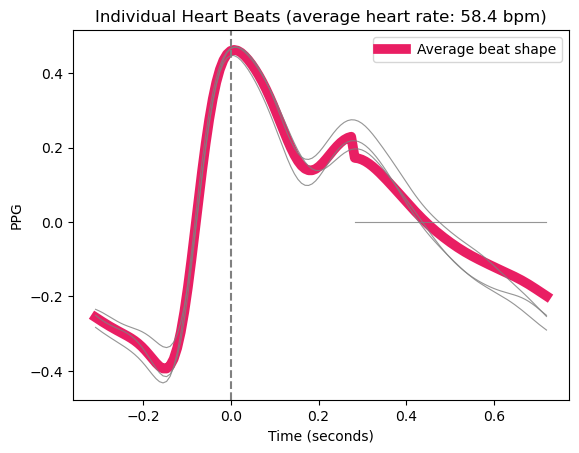

In [127]:
ppg = nk.ppg_simulate(duration=30, sampling_rate=100, heart_rate=80)

ppg_epochs = nk.ppg_segment(ppg_clean, sampling_rate=measureFrequency, show=True)

signal_array = ppg_epochs['2']

print(signal_array.index)

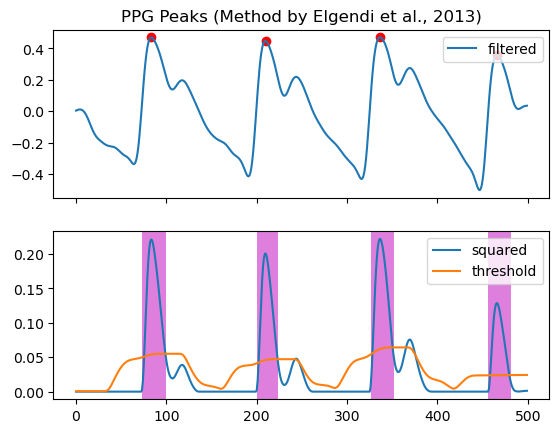

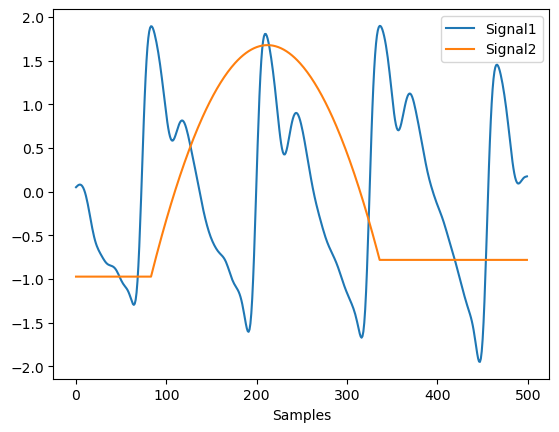

In [81]:
ppg_cleaned = nk.ppg_clean(irSignal, sampling_rate=measureFrequency, heart_rate=None, method="elgendi")

ppg_peaks = nk.ppg_findpeaks(ppg_cleaned, sampling_rate=measureFrequency, method='elgendi', show=True)

quality = nk.ppg_quality(normalize(ppg_cleaned, 0, 1), ppg_peaks["PPG_Peaks"],sampling_rate=measureFrequency, method="templatematch", approach=None)

nk.signal_plot([ppg_cleaned, quality], standardize=True)

(      PPG_Raw  PPG_Clean   PPG_Rate  PPG_Quality  PPG_Peaks
 0    0.537720   0.003637  58.251598     0.995548          0
 1    0.539786   0.006307  58.251598     0.995548          0
 2    0.542887   0.008640  58.251598     0.995548          0
 3    0.527385   0.010355  58.251598     0.995548          0
 4    0.540820   0.011195  58.251598     0.995548          0
 ..        ...        ...        ...          ...        ...
 495  0.826731   0.029468  57.206056     0.995772          0
 496  0.829142   0.031872  57.206056     0.995772          0
 497  0.834654   0.033485  57.206056     0.995772          0
 498  0.846021   0.034454  57.206056     0.995772          0
 499  0.838787   0.035082  57.206056     0.995772          0
 
 [500 rows x 5 columns],
 {'method_peaks': 'elgendi',
  'method_fixpeaks': 'None',
  'PPG_Peaks': array([ 83, 210, 336, 466]),
  'sampling_rate': 123.94645513138325})

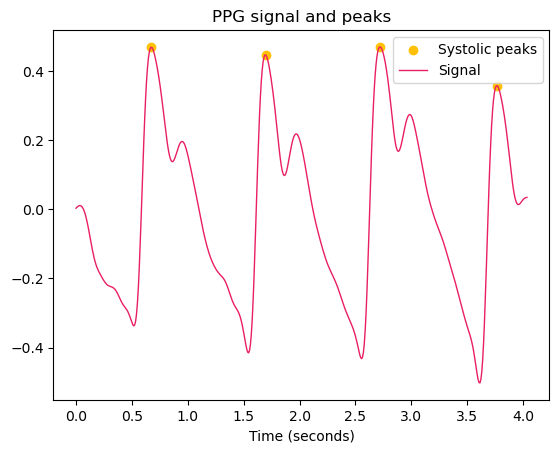

In [56]:
nk.ppg_process(irSignal, sampling_rate=measureFrequency, show=True)